# ADAMS | Final Assignment
### Name Surname: Baris Sen
### Matrikelnummer: 628530

#### Master Student


## Table of Contents

    1. Introduction
    2. Importing Libraries
    3. Data Import
    4. Getting to know Data
        4.1 Early Checks and Balances¶
        4.2 Ydata Profiling
        4.3 Data Sampling:
        4.4 Visualize Map Data
    5. Data Transformations
        5.1 Non-Text Data
            5.1.1 Date features
            5.1.2 Numeric features
            5.1.3 Categorical Features
            5.1.4 Binary Features
            5.1.5 Other Features: `Amenities`
            5.1.6 Location features `neighbourhood, zipcode, lat/long`
        5.2 Outlier Handling
        5.3 Scaling the numeric columns
        5.4 Cleaning the text features
    6. Target Distribution
    7. Final Data Preparation for Model Training
        7.1 Creating Embeddings for Text Features
        7.2 Seprate Embeddings for each Text Feature in to a Dict
        7.3 Stacking all Text Features in to 1 and Creating Embeddings¶
    8. Model Training
        8.1 Benchmark Models
            8.1.1 Linear Regression
            8.1.2 Linear Regression - Ridge Fit
            8.1.3 Random Forest
            8.1.4 XGBoost
        8.2 NLP + Neural Networks
            8.2.1 FNN
            8.2.1.1 Hyperparameter Tuning
            8.2.3 Final FNN
        8.3 RNN Architecture
            8.3.1 Simple GRU
            8.3.2 GRU with Glove
            8.3.3 Bi-directional GRU
        8.4 Commentary on the model comparison¶
        8.5 Adding Hyperparameter Tuning to Picked Model¶
        8.6 Stacked Model Approach
        8.7 Model with Separate Embedding Layers for Individual Text Features
        8.8 Working with Amenities column as a Embedding
        8.9 Final Comparison Of Models  
    9. Conclusion
    10. Predicting for the final test_data
        10.1 Preparing the Train_Data for Final Model
        10.2 Train & Predict with the Final Model

## 1. Introduction


In this assignment we are provided an Airbnb listing data from London together with reviews for these listings.
Our aim is provide predictions for the price of these listings in the test_data. Training data has tabular structure however we also have text features. As part of Adams course we are expected to explore NLP methods for dealing with text features and building Neural Network Models.

The following notebook is divided in to several sections.
First section being EDA, where we explore the provided data and trying to understand the features and relationships between features and targets.
In the second section we are going in to data cleaning and feature transformation.
In the next section we are dealing with text features by cleaning and creating embeddings.
The following section will be on Model Building and Assessment.
We will be building benchmark models with our tabular data for regression problem as well as will explore some Neural Network Architectures with the text features.
In the Final section we will have concluding remarks and commentary on the assignment and train the model again with full data and make predictions on the test data to provide for Kaggle competition.

## 2. Importing Libraries

In [26]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import polars as pl # this is a new library introduced, it is an augmented version of pandas and allows faster computation
import numpy as np
import re
import datetime as dt
import time
import textstat
import np_utils
import nltk
import warnings
from ydata_profiling import ProfileReport
from spellchecker import SpellChecker
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import emoji
from bs4 import BeautifulSoup
from collections import Counter
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Concatenate, Dense, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant
from tensorflow.keras import activations, losses
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.initializers import glorot_uniform


#map plotting libraries
import folium
from folium import plugins
from folium.plugins import HeatMap

##     3. Data Import

In [35]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
#review_data = pl.read_csv('data/reviews.csv') # as i am a master student, ignoring for now

In [36]:
train_data.shape, test_data.shape

((55284, 42), (29769, 41))

In [37]:
#len(review_data)

In [38]:
# Lets check the columns

In [39]:
train_data.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

In [40]:
test_data.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'house_rules', 'picture_url',
       'host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'zipcode', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'guests_included',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'cancellation_policy', 'reviews_per_month',
       'listing_id'],
      dtype='object')

We can already observe that training and test data set have same columns, so we do not need to be worried about excluding columns in prediction

Let's also have a quick glance in to the table.

In [41]:
train_data.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,...,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF


## 4. Getting to know Data

### 4.1 Early Checks and Balances

Let's check if there is one entry per listing:

In [42]:
len(pd.unique(train_data['listing_id'])), len(train_data)

(55284, 55284)

#### Early indications:
We already see that there is only 1 entry for each listing, so we have more of a dimension level data rather than fact data. \
Meaning we do also only have 1 price per listing (no change over time.) \
Makes our life easier as we are actually going to deal with tabular structures than sequantial data formats. \
For this reason in the earlier stages we can eliminate RNNs, LSTMs, or CNNs and work with feedforward networks.

In [43]:
train_data.dtypes

name                            object
summary                         object
space                           object
description                     object
experiences_offered             object
neighborhood_overview           object
transit                         object
house_rules                     object
picture_url                     object
host_id                          int64
host_since                      object
host_response_time              object
host_response_rate              object
host_is_superhost               object
host_total_listings_count      float64
host_has_profile_pic            object
host_identity_verified          object
neighbourhood                   object
neighbourhood_cleansed          object
zipcode                         object
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bathrooms                

We could deal most of the `review_scores_*` columns which are between 0 - 10 as categorical. However as we have other many categorical columns, in order to not increase cardinality, we will simply let the standardization deal with these columns.

`amenities`, `zipcode` columns are actually a categorical variable however it has high cardinality, so it is not as straightforward to deal with them. For this purpose we would actually use Embedding Layers to create continuous representations in the NLP model. However for Linear Benchmark Models, we will treat them as categorical after some transformation steps.

Embedding Layers: Embedding layers are commonly used to convert categorical variables into continuous representations. This is especially useful when dealing with high-cardinality categorical variables (those with a large number of categories). Embeddings map each category to a dense vector of lower dimensionality, capturing meaningful relationships between categories. Embedding layers are learnable parameters in the neural network that get updated during training.
(ref: https://chat.openai.com/share/c21ef873-a07e-457d-a31c-1bef992472bc)

We can drop neghbourhood column as we have the cleansed version

We can also drop `picture_url` and just check if pictures exists and create a binary column.

In [44]:
# columns below might not be in the intended data type yet, we will transform them further
columns_to_binary = ['host_is_superhost','host_has_profile_pic','host_identity_verified']
category_columns = ['experiences_offered', 'host_response_time', 'property_type', 'room_type', 'bed_type',
                    'cancellation_policy', 'neighbourhood_cleansed']
category_columns_big = ['neighbourhood_cleansed', 'zip_code', 'amenities']
text_columns = ['name','summary', 'space' , 'description', 'neighborhood_overview', 'transit', 'house_rules']
string_columns = ['listing_id'] # this is the unique identifier of the table (index)
numeric_columns = ['host_id', 'host_response_rate', 'host_total_listings_count', 'review_scores_rating' 
                   ,'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'reviews_per_month',
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location', 'review_scores_value']
target_column = ['price']

### 4.2 Ydata Profiling:
    
Y-data Profiling is a very powerful data visualizations library that gathers many early descriptive analytics we would do with 1 line of code and beautiful visualizations. (ref: https://ydata-profiling.ydata.ai/docs/master/index.html)
    
Next we will run Ydata - (used to be known as: Pandas Profiling to get early indicators, it already creates many descriptive analytics for our given data so we can use this and comment on the structures underlying in our training data.

!!! We provided the results of the Y-Data-Profiling separate as the visualization made the render of the notebooks noticably slower.

In [45]:
# We can generate quick descriptive analysis to have first look using ydata-profiling
#profile = ProfileReport(train_data.drop(columns=text_columns), title="Pandas Profiling Report")
#profile
#profile.to_file("airbnb_listing_pandas_profile.html")

#CAVEAT - This Pandas Profiling might be working different in Mac and Windows, this notebook has been prepared in Mac M1 - Python V: 3.9.10

**<ins>Commentary on the Pandas Profile Report<ins>**
    
- We can see that 9.1% of the cells are missing so we would need to deal with missing values.

When we check the Alerts:    
- `host_response_rate` is highly overall correlated with `host_response_time`. We can use only one.
-`latitude` and `longitude` columns are highly overall correlated with `neighbourhood_cleansed`. At this point we can consider using zipcode for this however zipcode has 1272 (2.3%) missing values which we can try to infer from other columns.
- `beds, bedrooms, accomodates` are highly correlated.
- we observe that target column `price` is highly overall correlated with accommodates.
- `review_scores` are overall correlated with each other.
- We observe that some columns are highly imblanced. `experiences_offered, bed_type` categorical so it is okay.
- Some of the textual columns: `space, neighbourhood_overview, transit, house_rules` has % of missing values.
    
Other Findings:
- Price column's interquartile rane is (IQR): 85, median:80, mean:104 where as 95-th percentile: 279, Maximum: 500. We might need to deal with outliers.

<ins>Dealing with multicollinearity:<ins> 
- (high correlation between predictor variables) can have negative impacts on the model's performance and interpretability. 
- There are several ways to deal with multicollinearity: 1- Feature Selection, 2- Feature Transformation:  like Principal Component Analysis (PCA), 3- Regularization 4- Using Feature Importance: like from a tree based model 5- Model Evaluation
- At this point we will prefer to use **Regularization** methods to deal with multicollinearity, and we would most probably go with **L2 Regularization (Ridge Regression):** method as L2 regularization adds the squared magnitudes of the coefficients as a penalty term to the cost function. It shrinks the coefficients toward zero without driving them exactly to zero. So you would eliminate the impact of multicollinearity but still won't loose features.

- Implementation of this will come later in the notebook.

### 4.3 Data Sampling:

Downsampling the data to increase speed would be beneficial.
In the end all the data transformation methods would be put in to a wrapper and applied to full data set for training and predicting on test data.

In [68]:
# Draw a random sample to save time
sample_size_train = 10000
np.random.seed(888)

#for train_data
idx = np.random.randint(low=0, high=train_data.shape[0], size=sample_size_train)
train_data_sample = train_data.loc[idx,:]

train_data_sample.reset_index(inplace=True, drop=True)  # dropping the index prohibits a reidentification of the cases in the original data frame
train_data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         9994 non-null   object 
 1   summary                      9463 non-null   object 
 2   space                        7028 non-null   object 
 3   description                  9705 non-null   object 
 4   experiences_offered          10000 non-null  object 
 5   neighborhood_overview        6532 non-null   object 
 6   transit                      6443 non-null   object 
 7   house_rules                  5755 non-null   object 
 8   picture_url                  10000 non-null  object 
 9   host_id                      10000 non-null  int64  
 10  host_since                   9986 non-null   object 
 11  host_response_time           6798 non-null   object 
 12  host_response_rate           6798 non-null   object 
 13  host_is_superhost

### 4.4 Visualizing Map Data:

In [69]:
##map 
#a map of London
London_Map = folium.Map(location=[51.509865, -0.118092],
                   zoom_start = 10)


# List comprehension to make a list of lists
heat_data = train_data_sample.loc[:,["latitude","longitude", "price"]] 
# we are using price as a "weight" to see the the focus areas that has higher number Airbnb listings with higher prices

# Plot it on the map
HeatMap(heat_data).add_to(London_Map)

# Display the map
London_Map

## 5. Data Transformations 

### 5.1 Non-Text Data

We can see that most of the columns are already in the right format.

Taking care of the non-text features of the data, by checking some of the columns

#### 5.1.1 Date features:

In linear regression model, benchmark models we can not use the date column so we would need to convert it to numeric

In [70]:
train_data_sample['host_since'] = pd.to_datetime(train_data_sample['host_since']).map(dt.datetime.toordinal)
train_data_sample['host_since'][1:10]

1    735171
2    737148
3    734492
4    737218
5    734018
6    735218
7    734699
8    736309
9    735126
Name: host_since, dtype: int64

<ins>Dealing with missing date columns:<ins>

In [71]:
train_data_sample.host_since.fillna(value = train_data_sample.host_since.median(), inplace = True)

#### 5.1.2 Numeric features:

In [72]:
train_data_sample.host_response_rate.unique()

array(['100%', nan, '90%', '96%', '93%', '70%', '86%', '97%', '88%',
       '80%', '0%', '60%', '33%', '71%', '92%', '79%', '99%', '85%',
       '50%', '74%', '98%', '81%', '75%', '83%', '89%', '30%', '87%',
       '67%', '95%', '94%', '78%', '40%', '91%', '82%', '20%', '25%',
       '54%', '68%', '69%', '72%', '29%', '56%', '84%', '77%', '38%',
       '65%', '43%', '73%', '57%', '63%', '10%', '44%', '17%', '64%',
       '31%', '62%', '23%', '13%', '47%', '55%', '41%', '58%'],
      dtype=object)

As there are many unique values, it is better not to treat as categorical but transform in to float.

In [73]:
def fix_host_response_rate(df):
    for t in df.index:
        df.loc[t, "host_response_rate"] = re.sub("%", "", str(df.host_response_rate[t]))
        if df.loc[t, "host_response_rate"] == "":
            df.loc[t, "host_response_rate"] = np.nan
    df.host_response_rate = df.host_response_rate.astype("float64")
    df.host_response_rate = df.host_response_rate/100 # lets turn them in to percentage
    df.host_response_rate.fillna(df.host_response_rate.median(), inplace=True) # replace the nan with Median
    
    print(df.host_response_rate.unique())
    
    return df.host_response_rate

In [74]:
train_data_sample.host_response_rate = fix_host_response_rate(train_data_sample)

[1.   0.9  0.96 0.93 0.7  0.86 0.97 0.88 0.8  0.   0.6  0.33 0.71 0.92
 0.79 0.99 0.85 0.5  0.74 0.98 0.81 0.75 0.83 0.89 0.3  0.87 0.67 0.95
 0.94 0.78 0.4  0.91 0.82 0.2  0.25 0.54 0.68 0.69 0.72 0.29 0.56 0.84
 0.77 0.38 0.65 0.43 0.73 0.57 0.63 0.1  0.44 0.17 0.64 0.31 0.62 0.23
 0.13 0.47 0.55 0.41 0.58]


**<ins> Dealing with missing numerical features:<ins>**

In [75]:
numeric_columns[1:]

['host_response_rate',
 'host_total_listings_count',
 'review_scores_rating',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'reviews_per_month',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [76]:
## Let's fill NAs with Median of the column
for col in numeric_columns[1:]:
    train_data_sample[col].fillna(value = train_data_sample[col].median(), inplace = True)

#### 5.1.3 Categorical Features

In [77]:
for col in category_columns:
    print(col)
    train_data_sample[col] = train_data_sample[col].replace(np.nan,"IsMissing") # lets also deal with ismissing here
    train_data_sample[col] = train_data_sample[col].astype('category') # change the datatype to. category

experiences_offered
host_response_time
property_type
room_type
bed_type
cancellation_policy
neighbourhood_cleansed


In [78]:
train_data_sample['host_response_time'].unique()

['within an hour', 'IsMissing', 'within a few hours', 'within a day', 'a few days or more']
Categories (5, object): ['IsMissing', 'a few days or more', 'within a day', 'within a few hours', 'within an hour']

In [79]:
category_columns

['experiences_offered',
 'host_response_time',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy',
 'neighbourhood_cleansed']

In [80]:
# Lets apply one-hot encoding to the categorical columns

encoder_dict = {}

def one_hot_encoding_train(df, col, encoder_dict):
    # Fit OneHotEncoder on training data
    encoder_dict[col] = OneHotEncoder(handle_unknown='ignore')
    encoder_dict[col].fit(df[[col]])
    # Transform
    encoded_train = encoder_dict[col].transform(df[[col]])
    # Convert encoded data to a DataFrame
    encoded_df_train = pd.DataFrame(encoded_train.toarray(), columns=encoder_dict[col].get_feature_names_out([col]))
    
    df_encoded = pd.concat([df, encoded_df_train], axis=1)
    # Concatenate the original data with the encoded DataFrame
    
    return df_encoded, encoder_dict

def one_hot_encoding_test(df, col, encoder_dict):
   
    # Transform
    encoded_test = encoder_dict[col].transform(df[[col]])
    # Convert encoded data to a DataFrame
    encoded_df_test = pd.DataFrame(encoded_test.toarray(), columns=encoder_dict[col].get_feature_names_out([col]))
    
    df_test_encoded = pd.concat([df, encoded_df_test], axis=1)
    # Concatenate the original data with the encoded DataFrame
    
    return df_test_encoded

In [81]:
for col in category_columns:
    train_data_sample, encoder_dict = one_hot_encoding_train(train_data_sample, col, encoder_dict)

In [82]:
# visualize an example
experiences_offered_cat_features = [col for col in train_data_sample if col.startswith('experiences_offered_')]
train_data_sample[experiences_offered_cat_features].head(3)

,experiences_offered_business,experiences_offered_family,experiences_offered_none,experiences_offered_romantic,experiences_offered_social
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0


#### 5.1.4 Binary Features:

In [83]:
train_data_sample.host_is_superhost.unique()

array(['t', 'f', nan], dtype=object)

In [84]:
# function to convert features from object to binary

def convert_into_binary(data_column):
    data_column = data_column.fillna('f') # we are dealing with missing values here by simply attaining false if missing
    data_column.replace(('t', 'f'), ('1', '0'), inplace=True)
    data_column = data_column.astype("float64")
    
    return data_column

In [85]:
# for loop to apply to all columns from object to binary

for column in columns_to_binary:
    train_data_sample[column] = convert_into_binary(train_data_sample[column])
    print(train_data_sample[column].unique())

[1. 0.]
[1. 0.]
[0. 1.]


In [86]:
train_data_sample[columns_to_binary].head(3)

,host_is_superhost,host_has_profile_pic,host_identity_verified
0,1.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0


In [87]:
train_data_sample[train_data_sample.picture_url.isna()]

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,neighbourhood_cleansed_Merton,neighbourhood_cleansed_Newham,neighbourhood_cleansed_Redbridge,neighbourhood_cleansed_Richmond upon Thames,neighbourhood_cleansed_Southwark,neighbourhood_cleansed_Sutton,neighbourhood_cleansed_Tower Hamlets,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster


All the listings seems to have a picture, so we do not create a `.ispictureexists` column.

#### 5.1.5 Other Features: `Amenities`

`Amenities` are the filters that we use to in Airbnb for finding what the listing has to offer. From own experience, they do play an important part in the decision and price of the apartment. For this reason we would like to encode them.

Another way to deal with `Amenities` column would be creating `embeddings` for this feature as the cardinality is very high. We will explore this further in the model training stage.

In [88]:
# Creating a set unique amenities
amenities_list = list(train_data.amenities)
amenities_list_string = " ".join(amenities_list).replace('{', '').replace('}', ',').replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',') if x.strip()]
amenities_set = set(amenities_set) # eliminates repeated words as sets have one value for unique
unique_amenities = list(amenities_set)
unique_amenities[:30]

['Buzzer/wireless intercom',
 'TV',
 'Extra space around bed',
 'Smoking allowed',
 'Dishwasher',
 'Outdoor kitchen',
 'Carbon monoxide detector',
 '24-hour check-in',
 'Stove',
 'Hair dryer',
 'translation missing: en.hosting_amenity_49',
 'Cat(s)',
 'Lake access',
 'Barbecue utensils',
 'Stair gates',
 'Central air conditioning',
 'Extra pillows and blankets',
 'Table corner guards',
 'Kitchen',
 'Dining table',
 'Refrigerator',
 'Dining area',
 'Paid parking off premises',
 'Pets allowed',
 'Shared pool',
 'Tennis court',
 'Paid parking on premises',
 'Other',
 'Hot water',
 'Ground floor access']

In [89]:
def encoding_amenity(df, unique_amenities_list):
    # Create encoding for every amenity
    encoded_columns = {} # dict for encoded columns

    for amenity in unique_amenities_list:
        encoded_columns[f'amenity:{amenity}'] = df['amenities'].str.contains(amenity, regex=False).astype('float64')

    # Convert the dictionary of encoded columns into a DataFrame
    encoded_df = pd.DataFrame(encoded_columns)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

In [90]:
train_data_sample = encoding_amenity(train_data_sample, unique_amenities)
train_data_sample.head(3)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,amenity:Memory foam mattress,amenity:Espresso machine,amenity:Sound system,amenity:Waterfront,amenity:Wine cooler,amenity:Firm mattress,amenity:Amazon Echo,amenity:Handheld shower head,amenity:Beachfront,amenity:Oven
0,one modern bedroom flat in zone 2,One modern bedroom flat in a quiet building lo...,The flat is on the second floor of a building ...,One modern bedroom flat in a quiet building lo...,none,Quiet cool-de-sac but 5 minutes away from Kent...,Kentish Town undeground is on the northern lin...,- No shoes in the house,https://a0.muscache.com/im/pictures/aab7be23-e...,15364164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Beauitiful Mordern House Ensuite Spacious,"A lovely modern quiet house , continental brea...",A lovely quiet space with a beautiful garden t...,"A lovely modern quiet house , continental brea...",none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/26008237/1...,9715478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Luxurious 6bed Flat in Marble Arch,NaN,NaN,NaN,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/ec2df8a4-c...,252117300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# filtering amenities features
filter_col_amenity = [col for col in train_data_sample if col.startswith('amenity')]

Next we will try to understand which of the listed amenities actually have a significant impact on the target.
For this we will first visualize some of them [3]. Then we will just check the p_score and gather the significant amenities features in to a list to filter.

In [92]:
def category_to_price_with_visualization(df, col, figsize=(6,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A t-test P-value is calculated. Tells if the effect we get from this amenity has significant impact on the price.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=10, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0, fontsize=10)
    ax1.set_title('Category count', fontsize=10)
    ax1.set_xlabel('', fontsize=10)
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0, fontsize=10)
    ax2.set_title('Median Price', fontsize=10)
    ax2.set_xlabel('', fontsize=10)
    plt.show()
    
    cat0 = df.loc[df[col] == 0.0].price
    cat1 = df.loc[df[col] == 1.0].price
    tstatistic, pvalue = ttest_ind(cat0, cat1)
    
    cat0_median =(df.loc[df[col] == 0.0].price.median())
    cat1_median = (df.loc[df[col] == 1.0].price.median())
    cat0_count =(df.loc[df[col] == 0.0].price.count())
    cat1_count =(df.loc[df[col] == 1.0].price.count())
    print("")
    print('P-value is %6.2e' % pvalue)
    print(str(col)+" - False | Category Count :" + str(cat0_count) + ", Median Price:" + str(cat0_median))
    print(str(col)+" - True  | Category Count :" + str(cat1_count) + ", Median Price:" + str(cat1_median))

    # Bonferroni correction for multiple hypothesis testing:
    if pvalue < (0.05/106):
        print("Effect is significant!")
        
        df.groupby(col).price
        return pvalue, col
    
    # we are only going to take in the significant amenity features for model.
    else:
        df.groupby(col).price
        return pvalue, np.NaN

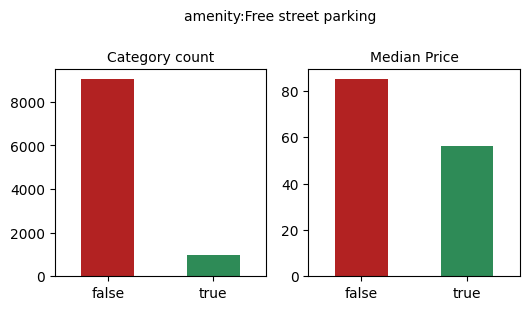


P-value is 5.07e-27
amenity:Free street parking - False | Category Count :9037, Median Price:85.0
amenity:Free street parking - True  | Category Count :963, Median Price:56.0
Effect is significant!


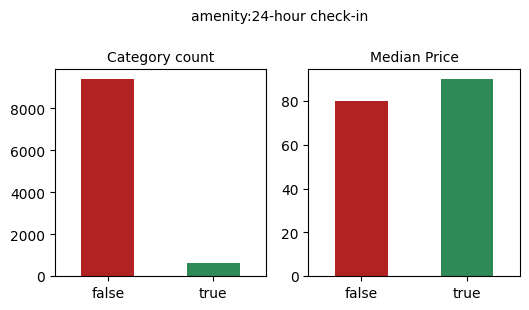


P-value is 1.40e-02
amenity:24-hour check-in - False | Category Count :9388, Median Price:80.0
amenity:24-hour check-in - True  | Category Count :612, Median Price:90.0


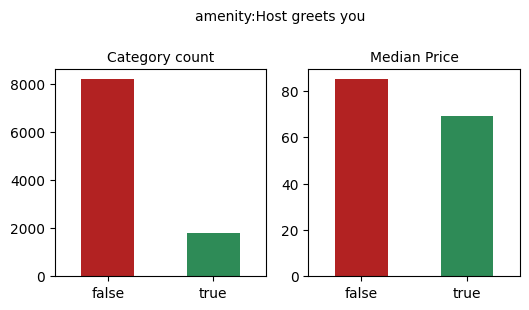


P-value is 1.87e-09
amenity:Host greets you - False | Category Count :8209, Median Price:85.0
amenity:Host greets you - True  | Category Count :1791, Median Price:69.0
Effect is significant!


In [93]:
# Let's use the visualization for only some of the amenity features first for depiction
short_list_amenity = ['amenity:Free street parking' ,'amenity:24-hour check-in', 'amenity:Host greets you']
for col in short_list_amenity:
    _, p_sign_col = category_to_price_with_visualization(train_data_sample, col)

In [94]:
# Lets create a function to go over all amenities without visualization
# and gathers the significant features in to alist 
def category_to_price_without_visualization(df, col):
    
    cat0 = df.loc[df[col] == 0.0].price
    cat1 = df.loc[df[col] == 1.0].price
    tstatistic, pvalue = ttest_ind(cat0, cat1)
    
    cat0_median =(df.loc[df[col] == 0.0].price.median())
    cat1_median = (df.loc[df[col] == 1.0].price.median())
    cat0_count =(df.loc[df[col] == 0.0].price.count())
    cat1_count =(df.loc[df[col] == 1.0].price.count())

    # Bonferroni correction for multiple hypothesis testing:
    if pvalue < (0.05/106):
        
        df.groupby(col).price
        return pvalue, col
    
    # we are only going to take in the significant amenity features for model.
    else:
        df.groupby(col).price
        return pvalue, np.NaN

In [95]:
import warnings
# We are going to Filter warnings for this cell as ttest is throwing a lot of warnings
# Filter out the specific warning category you want to suppress
warnings.filterwarnings("ignore")

list_sign_cols = []
for col in filter_col_amenity:
    _, p_sign_col = category_to_price_without_visualization(train_data_sample, col)
    list_sign_cols.append(p_sign_col)
    
list_sign_cols = set(list_sign_cols) # eliminates repeated words as sets have one value for unique
amenities_psign_features = list(list_sign_cols)
amenities_psign_features.remove(np.nan)

# Reset the warnings to their default behavior
warnings.resetwarnings()

We can already see that many of the amenities features would play a significant role in the price prediction.
The amenities we see no significant effect can be removed from the final set of features.

In [96]:
len(amenities_psign_features), len(filter_col_amenity)

(95, 200)

In [97]:
# droppping insignificant amenity features
remove_list = [item for item in filter_col_amenity if item not in amenities_psign_features]
train_data_sample.drop(columns=remove_list, inplace=True)

#### 5.1.6 Location features `neighbourhood, zipcode, lat/long`

In [98]:
train_data_sample.neighbourhood_cleansed.nunique(), train_data_sample.zipcode.nunique()

(33, 6800)

We can see that Zipcode has a lot of unique values where as Neighbourhood cleansed only has 33 distinct categories.
To make our life easier, we decide to ignore zipcodes and lattitude, longitude variables for now and deal with neighbourhood_cleansed.
We re aware that it would make us loose certain details and power of the model. For ex. certain street having a special value in a neighbourhood than others. But for now we would ignore this.

### 5.2 Outlier Handling

below **Inter Quantile Range - IQR** method is being used. This is a very rigid model and sometimes might oversee some information that is vital to the predictability of the model.

The idea behind is that, we define an upper and lower bound for data, and outliers outside these bounds are truncated/winsorized to the bounds.

The default method would be Tuckey's rule using 1.5 by default for IQR. However this is a rigid rule and I would like to use a more conservative range to capture more of the data so i will apply **2.5** instead of 1.5.

In [99]:
def outlier_truncation(x, factor=2.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new, IQR

In [100]:
## next outlier truncation to be used for test data while prividing IQR from training data

def outlier_truncation_with_IQR(x, IQR, factor=2.5,):
    ''' 
    This one is created to be used in Test Column 
    to use the same IQR values trained in Training data 
    while transforming test data
    '''
    x_new = x.copy()
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

In [101]:
#num_col_to_handle.clear()
num_col_to_handle = numeric_columns.copy()
num_col_to_handle.remove('host_id')

In [102]:
num_col_to_handle

['host_response_rate',
 'host_total_listings_count',
 'review_scores_rating',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'reviews_per_month',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [105]:
IQR_dict = {}
for col in num_col_to_handle:
    train_data_sample[col], IQR_dict[col] = outlier_truncation(train_data_sample[col])

In [106]:
train_data_sample.review_scores_rating[0:3]

0    99.0
1    95.0
2    95.0
Name: review_scores_rating, dtype: float64

### 5.3 Scaling the numeric columns

We have noticed before that different variables have different scales.
So we would like to apply standardization or scaling techqniques here to increase predictability as different scales might yield to wrong assumptions based on predictive power of features.

We have options Standardization (Z-score normalization) or Scaling (Min-Max Scaling or Max Absolute Scaling):

We have seen in some of the article that in Neural Network problems Scaling is more preferred method. Neural Scaling/Normalization features to a smaller range (e.g., [0, 1] or [-1, 1]) helps the optimization process.

(ref: https://chat.openai.com/share/b1f08ab8-f6b3-480b-882b-54fd2fea101f)

**!!! However we need to be careful to use the fit the scaling model only on `train_data` and use the same fitted model for test set.**

In [107]:
for col in num_col_to_handle:
    scaler = MinMaxScaler() #re/initialize scaler for each column
    scaler.fit(train_data_sample[[col]])

    scaled_column_train = scaler.transform(train_data_sample[[col]]) #transfor train_data

    # Option 1: Update existing DataFrame
    train_data_sample[f'scaled_{col}'] = scaled_column_train

In [108]:
train_data_sample.scaled_review_scores_rating[:3]

0    0.956522
1    0.782609
2    0.782609
Name: scaled_review_scores_rating, dtype: float64

### 5.4 Cleaning the text features


In [109]:
for col in text_columns:
    train_data_sample[col] = train_data_sample[col].astype(str)

In [110]:
## download pre-learned NLP tools
nltk.download('stopwords') ## to identify stopwords 
nltk.download('averaged_perceptron_tagger') ## for part-of-speech tagging (used for lemmatization)
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

## Lemmatize with POS Tag (Parts of Speech tagging)
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

## fixes the word lengthening issues when characters are wrongly repeated ex: finalllly
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def remove_whitespace(text):
    """ Function to remove whitespace (tabs, newlines). """
    return ' '.join(text.split())

## function to clean text data
def clean_texts(df):
    """ Standard NLP pre-processing chain including removal of html tags, non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    cleaned_text = []
    lemmatizer = WordNetLemmatizer()
    print('*' * 40)
    print('Cleaning {} texts in the column.'.format(df.shape[0]))
    counter = 0
    for text in df:
        #conver to string as a check
        text = str(text)
        #make small letters
        text = str.lower(text)
        # remove newlines
        text = text.replace("\n", " ")
        text = text.replace("\xa0", " ")
        # remove html content
        text = BeautifulSoup(text).get_text()
        
        # remove non-alphabetic characters
        text = re.sub("[^a-zA-Z]"," ", text)
        
        # context specific words to fix:
        text = text.replace("comfi", "comfortable")
        text = text.replace("ppl", "people")
        text = text.replace("bd", "bedroom")
        
        # lets deemojinize the emojis if it exists as it might increase meaning and remove white spaces
        text = remove_whitespace(emoji.demojize(text))
        
        # tokenize the sentences with all capital letters transformed to lower case
        words = word_tokenize(text.lower())

        # Spellcheck and correction
        #spell = SpellChecker()
        #words = [spell.correction(word) for word in words] # this spell checker makes the results quite slow, i can consider to avoid it.
        
        # filter stopwords
        stop_words = set(stopwords.words("english"))
        filtered_words = [w for w in words if w not in stop_words]
        
        # we pick lemmatization over stemming as it carries contextual meaning as well.
        # lemmatize each word to its lemma
        text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]) # lemmatize each word
        
        cleaned_text.append(text)
              
        if (counter > 0 and counter % 1000 == 0):
            print('Processed {} texts'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(cleaned_text) 

[nltk_data] Downloading package stopwords to /Users/bsen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bsen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/bsen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bsen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bsen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [111]:
# Let's loop thru all the text features in our dataset for cleaning and creates the cleaned version of them.

for column_name in text_columns:
    print('Dealing with column: {}'.format(column_name))
    train_data_sample['clean_{}'.format(column_name)] = clean_texts(train_data_sample[column_name])
    print()

Dealing with column: name
****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************

Dealing with column: summary
****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************

Dealing with column: space
****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************

Dealing with column: description
****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************

Dealing with column: neighborhood_overview
****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************

Dealing with column: transit
****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************

Dealing with column: house_rules
****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************



In [112]:
train_data_sample.head(3)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,scaled_review_scores_communication,scaled_review_scores_location,scaled_review_scores_value,clean_name,clean_summary,clean_space,clean_description,clean_neighborhood_overview,clean_transit,clean_house_rules
0,one modern bedroom flat in zone 2,One modern bedroom flat in a quiet building lo...,The flat is on the second floor of a building ...,One modern bedroom flat in a quiet building lo...,none,Quiet cool-de-sac but 5 minutes away from Kent...,Kentish Town undeground is on the northern lin...,- No shoes in the house,https://a0.muscache.com/im/pictures/aab7be23-e...,15364164,...,0.0,1.0,1.000000,one modern bedroom flat in zone,one modern bedroom flat in a quiet building lo...,the flat be on the second floor of a building ...,one modern bedroom flat in a quiet building lo...,quiet cool de sac but minute away from kentish...,kentish town undeground be on the northern lin...,no shoe in the house
1,Beauitiful Mordern House Ensuite Spacious,"A lovely modern quiet house , continental brea...",A lovely quiet space with a beautiful garden t...,"A lovely modern quiet house , continental brea...",none,nan,nan,nan,https://a0.muscache.com/im/pictures/26008237/1...,9715478,...,0.0,1.0,0.714286,beauitiful mordern house ensuite spacious,a lovely modern quiet house continental breakf...,a lovely quiet space with a beautiful garden t...,a lovely modern quiet house continental breakf...,nan,nan,nan
2,Luxurious 6bed Flat in Marble Arch,nan,nan,nan,none,nan,nan,nan,https://a0.muscache.com/im/pictures/ec2df8a4-c...,252117300,...,0.0,1.0,0.714286,luxurious bed flat in marble arch,nan,nan,nan,nan,nan,nan


In [113]:
filter_clean_text_features = ['clean_name' , 'clean_space', 'clean_description' , 'clean_neighborhood_overview', 'clean_transit', 'clean_house_rules']

In [115]:
# Let's save our cleaned and prepared data before going further

#with open('train_data_sample.pkl', 'wb') as file_name:
#    pickle.dump(train_data_sample, file_name)

In [220]:
# Let's load our cleaned and prepared data before going further

with open('train_data_sample.pkl', 'rb') as file_name:
    train_data_sample = pickle.load(file_name)

## 6. Target Distribution
Let's check the target distribution for train data 

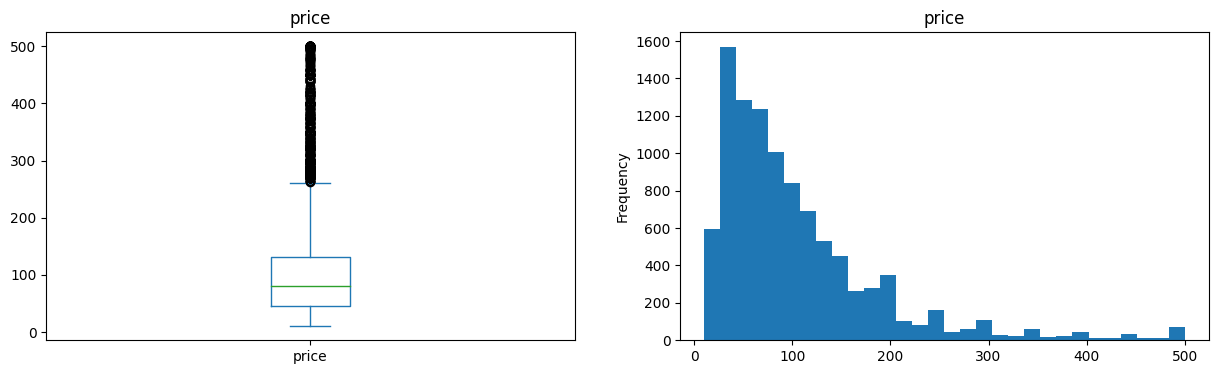

In [117]:
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title("price")
train_data_sample.price.plot.box();
plt.subplot(1, 2, 2)
plt.title("price")
train_data_sample.price.plot.hist(bins=30);

We can see that the price data is skewed and we can also observe many outliers.
Also normally in Airbnb listings change their price over the course of time or between seasons.
However this is not represented in data as we have only 1 row per listing_id. The data is more like a dimension table or a snapshot. This makes our lives easier.

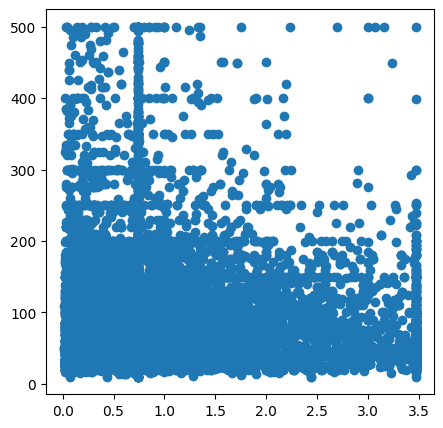

In [118]:
plt.figure(figsize=(5,5)) 
plt.scatter(train_data_sample.reviews_per_month, train_data_sample.price)

We see that majority of the listings does not recieve reviews every month, how are we going to deal with this.

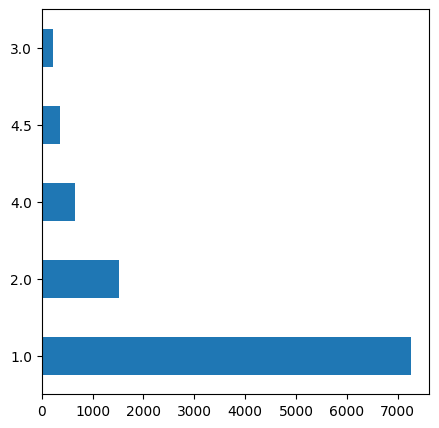

In [119]:
plt.figure(figsize=(5,5))
train_data_sample.guests_included.value_counts().plot.barh();

This is similar to the heatmap we build above, lets try to put neighbourhoods by median price

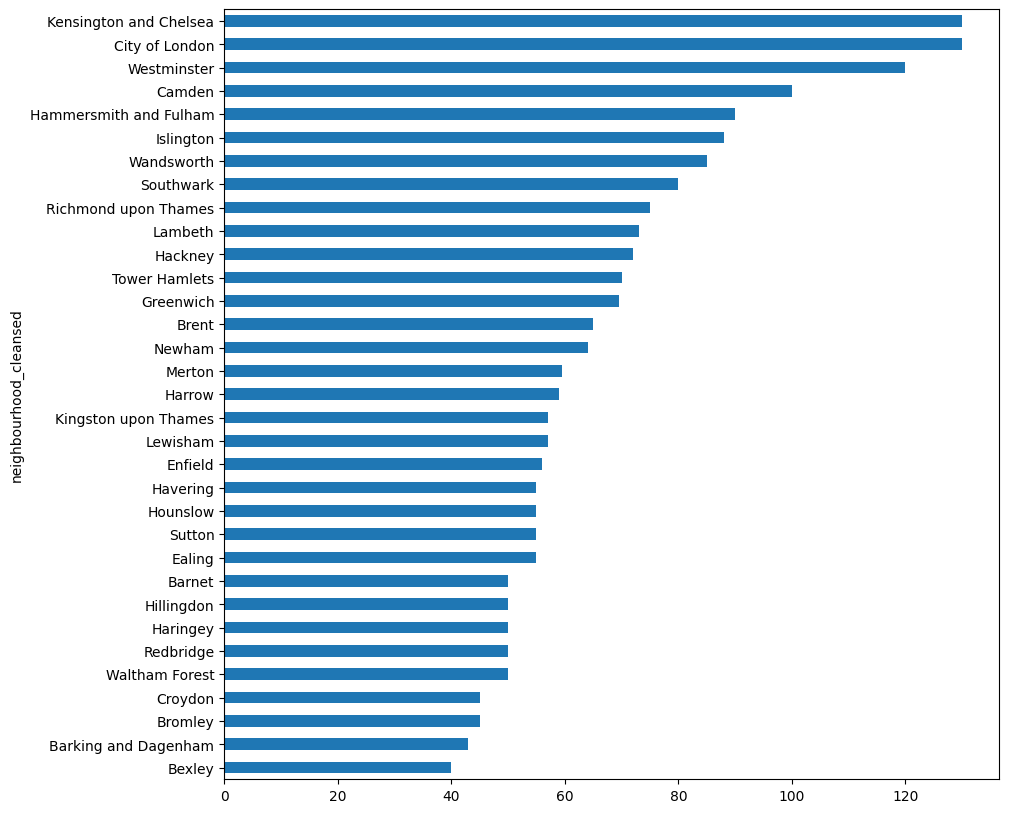

In [120]:
plt.figure(figsize=(10,10)) 
train_data_sample.groupby('neighbourhood_cleansed')['price'].median().sort_values().plot.barh();

Looking just at the median without any other features of the listings we can see that London Inner City, Kensington and Chelsea are the most expensive neighbourhoods.

## 7. Final Data Preparation for Model Training

Underlying problem with our data set is that it has both textual and numerical columns that would be used in order to fit the model to train as well as predict on the test data.

To train a neural network with data that contains both textual and numerical features, we'll need to use a multi-input model in Keras. 
A multi-input model allows you to create a neural network architecture that takes multiple inputs, processes them separately, and then combines the information for prediction.

Basically we will clean, tokenize and create embeddings for our textual data, train the model by using multiple input, where as we will treat numerical data as a separate input in the model.fit stage.

In [221]:
# Stacking all the text_features together
train_data_sample['all_text_features'] = train_data_sample['name'] + train_data_sample['space'] + train_data_sample['description'] +train_data_sample['neighborhood_overview'] +train_data_sample['transit'] +train_data_sample['house_rules']
train_data_sample['all_text_features'].fillna('', inplace=True)
train_data_sample['clean_all_text_features'] = clean_texts(train_data_sample['all_text_features'])

filter_col_scaled = [col for col in train_data_sample if col.startswith('scaled')]
filter_cat_features = []
for feat in category_columns:
    cat_feature_list = [col for col in train_data_sample if col.startswith(str(feat))]
    filter_cat_features.extend(cat_feature_list)
filter_col_amenity = [col for col in train_data_sample if col.startswith('amenity')]
filter_col_clean_text = [col for col in train_data_sample if col.startswith('clean_')]
other_features = ['host_since','host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
benchmark_model_features = filter_col_scaled + filter_cat_features + other_features + filter_col_amenity + filter_col_clean_text

train_data_sample.drop(columns = category_columns, inplace=True)
benchmark_model_features = [x for x in benchmark_model_features if x not in category_columns]

****************************************
Cleaning 10000 texts in the column.


/var/folders/ty/_yzbf6z93l92qxz8v51lj8xm0000gp/T/ipykernel_62205/3001552301.py:47: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text).get_text()


Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
DONE
****************************************


In [135]:
seed = 42
# for full model
X_train, X_test, y_train, y_test = train_test_split(train_data_sample[benchmark_model_features], train_data_sample['price'], test_size=0.20, random_state=seed)

# convert all numeric columns to float
X_train_wo_clean_text = np.asarray(X_train.drop(columns=filter_col_clean_text)).astype('float32')
X_test_wo_clean_text = np.asarray(X_test.drop(columns=filter_col_clean_text)).astype('float32')
#X_train_wo_clean_text = np.asarray(X_train.drop(columns='clean_description')).astype('float32')

#### After that let's create embeddings matrix for train and test split.

<ins>Creating Embedding Matrix together with all text columns:<ins>

As we have multiple text features, we need to find a way to deal with them in the embedding layer.
There are 2 options:
1. We could concatenate the the two features into one and create a single embedding for both of them.
2. Or We can learn multiple embeddings and concatenate them while training.

### 7.1 Creating Embeddings for Text Features

Using Wiki2vec pre-trained embeddings model downloaded.
We need to prepare our text data to be used for our NLP model.
For that we decided to use pre-trained embeddings: we decide to go with 100-dimensional wiki2vec embeddings from https://wikipedia2vec.github.io/wikipedia2vec/pretrained/.
We will investigate other dimensions further in the model.

In [136]:
# First lets define the functions that gets us the embedding matrix
# this function is taken from demos/nlp/sentiment_analysis.ipynb from class material

def get_embedding_matrix(tokenizer, pretrain, vocab_size, verbose=0):
    '''
        Helper function to construct an embedding matrix for 
        the focal corpus based on some pre-trained embeddings.
    '''
    
    dim = 0
    # We will use the function with different types of embeddings. Therefore, 
    # we need a condition to determine what is the right way of determining
    # the embedding dimension. 
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    
    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding.
    # In this tutorial, we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    v = len(tokenizer.word_index)
    start = time.time()
    print('Start embedding process for {} words.'.format(v), flush=True)
    
    for word, i in tokenizer.word_index.items():  
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
        # Some output that the method is still alive
        if i % 5000 == 0 and verbose>0:    
            print('{}/{} words in {} sec'.format(i, v, (time.time()-start)), flush=True)
            
            
    print('Created embedding matrix of shape {} in {} min '.format(emb_mat.shape, (time.time()-start)/60))
    
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [137]:
# Load wiki2vec embeddings:
start = time.time()
wiki2vec = KeyedVectors.load_word2vec_format('data/enwiki_20180420_100d.txt')
end = time.time()
print(f"Loaded wiki2vec embeddings in {end - start} seconds.")

Loaded wiki2vec embeddings in 161.4931080341339 seconds.


Creating Embedding Matrix for the text features separately and collecting results in a dictionary

### 7.2 Creating Seprate Embeddings for each Text Feature in to a Dict

In [138]:
def pretrained_emb_matrix_dict_creator(tr_df, ts_df ,text_columns):
    
    # This List IDEA is confusing and time consuming for now, deal with it later
    embedding_weights_dic = {}
    num_words_dict = {}
    max_text_length_dic = {}
    tr_padded_text_dict = {}
    ts_padded_text_dict = {}

    for col in text_columns:

        print('Now dealing with columng `{}`.'.format(col))

        tokenizer_col = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
        tr_df[col] = tr_df[col].fillna('')
        tokenizer_col.fit_on_texts(tr_df[col])
        NUM_WORDS_TEXT = len(tokenizer_col.word_index) + 1
        print('Printing NUM_WORDS_TEXT in text:'+str(NUM_WORDS_TEXT))

        df_text_seq = tokenizer_col.texts_to_sequences(tr_df[col])
        max_article_length = max([len(article) for article in df_text_seq])
        print('The longest article of the training set has {} words.'.format(max_article_length))

        # Upper bound of the article length for padding
        MAX_TEXT_LENGTH = max_article_length #using max sentence length as the uppor bound for padding for each column
        df_text_seq_padded = pad_sequences(df_text_seq, MAX_TEXT_LENGTH)

        # Encode and pad the test data using the tokenizer trained with training data
        ts_text_seq = tokenizer_col.texts_to_sequences(ts_df[col]) 
        ts_text_pad = pad_sequences(ts_text_seq, MAX_TEXT_LENGTH)

        wiki_weights_text, _ = get_embedding_matrix(tokenizer_col, wiki2vec, NUM_WORDS_TEXT)
                            
        embedding_weights_dic[col] = wiki_weights_text
        tr_padded_text_dict[col] = df_text_seq_padded
        num_words_dict[col] = NUM_WORDS_TEXT
        max_text_length_dic[col] = MAX_TEXT_LENGTH
        ts_padded_text_dict[col] = ts_text_pad
        print()
        
    return embedding_weights_dic, tr_padded_text_dict, ts_padded_text_dict, num_words_dict, max_text_length_dic

In [211]:
tr_embedding_weights_dic = {}
padded_text_dict = {}
num_words_dict = {}
max_text_length_dic = {}
ts_padded_text_dict = {}

tr_embedding_weights_dic, tr_padded_text_dict, ts_padded_text_dict, num_words_dict, max_text_length_dic =  pretrained_emb_matrix_dict_creator(X_train, X_test, filter_clean_text_features)

Now dealing with columng `clean_name`.
Printing NUM_WORDS_TEXT in text:2383
The longest article of the training set has 15 words.
Start embedding process for 2382 words.
Created embedding matrix of shape (2383, 100) in 0.004580295085906983 min 
Encountered 177 out-of-vocabulary words.

Now dealing with columng `clean_space`.
Printing NUM_WORDS_TEXT in text:7967
The longest article of the training set has 200 words.
Start embedding process for 7966 words.
Created embedding matrix of shape (7967, 100) in 0.0036719481150309244 min 
Encountered 540 out-of-vocabulary words.

Now dealing with columng `clean_description`.
Printing NUM_WORDS_TEXT in text:12106
The longest article of the training set has 206 words.
Start embedding process for 12105 words.
Created embedding matrix of shape (12106, 100) in 0.0033640146255493166 min 
Encountered 1406 out-of-vocabulary words.

Now dealing with columng `clean_neighborhood_overview`.
Printing NUM_WORDS_TEXT in text:8898
The longest article of the tra

In [3407]:
# dealing with clean_summary first

tokenizer_summary = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_summary.fit_on_texts(X_train.clean_summary)
NUM_WORDS_TEXT = len(tokenizer_summary.word_index) + 1
print('Printing NUM_WORDS_TEXT in text:'+str(NUM_WORDS_TEXT))

tr_x_smpl_summary_seq = tokenizer_summary.texts_to_sequences(X_train.clean_summary)
max_article_length = max([len(article) for article in tr_x_smpl_summary_seq])
print('The longest article of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_TEXT_LENGTH = max_article_length #using max sentence length as the uppor bound for padding for each column
tr_x_smpl_summary_pad = pad_sequences(tr_x_smpl_summary_seq, MAX_TEXT_LENGTH)

wiki_weights_summary, _ = get_embedding_matrix(tokenizer_summary, wiki2vec, NUM_WORDS_TEXT)

Printing NUM_WORDS_TEXT in text:7450
The longest article of the training set has 182 words.
Start embedding process for 7449 words.
Created embedding matrix of shape (7450, 100) in 0.0007532636324564616 min 
Encountered 578 out-of-vocabulary words.


In [3408]:
# dealing with clean_description

tokenizer_description = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_description.fit_on_texts(X_train.clean_description)
NUM_WORDS_TEXT = len(tokenizer_description.word_index) + 1
print('Printing NUM_WORDS_TEXT in text:'+str(NUM_WORDS_TEXT))


tr_x_smpl_description_seq = tokenizer_description.texts_to_sequences(X_train.clean_description)
max_article_length = max([len(article) for article in tr_x_smpl_description_seq])
print('The longest article of the training set has {} words.'.format(max_article_length))


# Upper bound of the article length for padding
MAX_TEXT_LENGTH = max_article_length #using max sentence length as the uppor bound for padding for each column
tr_x_smpl_description_pad= pad_sequences(tr_x_smpl_description_seq, MAX_TEXT_LENGTH)


wiki_weights_description, _ = get_embedding_matrix(tokenizer_description, wiki2vec, NUM_WORDS_TEXT)

Printing NUM_WORDS_TEXT in text:12104
The longest article of the training set has 206 words.
Start embedding process for 12103 words.
Created embedding matrix of shape (12104, 100) in 0.0014579017957051595 min 
Encountered 1406 out-of-vocabulary words.


**7.1.1.2 Comparing `summary` with `description` text features**

From the initial look at the `train.csv` we had the the idea that description and the summary column are quite similar. They seemed to have started with the same sentences. The initial idea was to maybe removing one of the columns.

So we wanted to check actually if these two columns are also pretty much same by using the cosine similarity based on their embedding matrix below.

In [3409]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(wiki_weights_summary, wiki_weights_description)

np.mean(similarity_matrix)

0.21689782994429033

Their cosine similarity score is pretty low considering that this values ranges between (-1,1). 1 being eaxct same and -1 being very different.

By checking these two columns we also notice that summary is just a shorter version of description, there fore can be excluded in the feature matrix while training the model. 
- Later we can check if adding this to the model actually increases accuracy or not?
- We can also use summary to replace description column if there are any entries where summary is not null and decription is null

In [3426]:
len(train_data[pd.isnull(train_data.description) & pd.notnull(train_data.summary)])

0

There is no row where summary is filled and description is empty. We can simply exclude summary feature further.

Keep on creating rest of the embedding features.

### 7.3 Stacking all Text Features in to 1 and Creating Embeddings

In [139]:
# dealing with clean_all_text_features

tokenizer_all_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
tokenizer_all_text.fit_on_texts(X_train.clean_all_text_features)
NUM_WORDS_ALL_TEXT = len(tokenizer_all_text.word_index) + 1
print('Printing NUM_WORDS_TEXT in text:'+str(NUM_WORDS_ALL_TEXT))

# Convert training set clean_all_text_festures to sequences of integer values
tr_all_text_seq = tokenizer_all_text.texts_to_sequences(X_train.clean_all_text_features)

max_article_length = max([len(article) for article in tr_all_text_seq])
print('The longest article of the training set has {} words.'.format(max_article_length))

# Upper bound of the article length for padding
MAX_ALL_TEXT_LENGTH = max_article_length #using max sentence length as the uppor bound for padding for each column

# We can also set an arbitrary boun: this would be setting an absolute number for upbound for padding.
#All reviews that are shorter than our upper bound will be padded with zeros. Longer reviews will be truncated.
#MAX_ALL_TEXT_LENGTH = 900 
print('MAX_ALL_TEXT_LENGTH:'+str(MAX_ALL_TEXT_LENGTH))

# Pading training data
tr_all_text_pad = pad_sequences(tr_all_text_seq, MAX_ALL_TEXT_LENGTH)

# Encode and pad the test data using the tokenizer trained with training data
ts_all_text_seq = tokenizer_all_text.texts_to_sequences(X_test.clean_all_text_features) 
ts_all_text_pad = pad_sequences(ts_all_text_seq, MAX_ALL_TEXT_LENGTH)

wiki_weights_all_text, _ = get_embedding_matrix(tokenizer_all_text, wiki2vec, NUM_WORDS_ALL_TEXT)

Printing NUM_WORDS_TEXT in text:26706
The longest article of the training set has 923 words.
MAX_ALL_TEXT_LENGTH:923
Start embedding process for 26705 words.
Created embedding matrix of shape (26706, 100) in 0.0018846352895100912 min 
Encountered 11670 out-of-vocabulary words.


From 26K NUM of WORDS we see 11K out of vocabulary words. This number is quite big.
We might need to look in to this later.

## 8. Model Training


### 8.1 Benchmark Models

To be able to judge the performance of our final model, we introduce some more naive models in order to have a couple of benchmark performance thresholds.

1. A linear regression on non-text features
2. A Random Forest on non-text features
3. An xgb model on non-text features
4. A basic GRU with self-trained embeddings on text features

In [140]:
# Let's callect all our model MAE and RMSE scores in to a model for comparison.
MAE_dict = {}
RMSE_dict = {}

#### 8.1.1 Linear Regression

In [141]:
## Linear Regression

linear_reg_model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())
linear_reg_model.fit(X_train_wo_clean_text, y_train)

prediction = pd.DataFrame({"Prediction": linear_reg_model.predict(X_test_wo_clean_text), "Actual": y_test})

print(f"R2: {linear_reg_model.score(X_test_wo_clean_text, y_test)}")
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"RMSE: {np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

R2: 0.5354798455065006
MSE: 3289.458521484375
RMSE: 57.35380128190611
MAE: 36.84578125


R^2 indicates how much of the variance in the input data can be explained by the model. It comments on the fit of the model.

In [143]:
# Let's add each model's performance to compare in the end.
MAE_dict['linear_reg'] = mean_absolute_error(prediction.Actual, prediction.Prediction)
RMSE_dict['linear_reg'] = np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))

#### 8.1.2 Linear Regression - Ridge Fit

In [144]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=20.0) # We are introducing L2 Ridge Penalty here.

ridge_reg.fit(X_train_wo_clean_text, y_train)

prediction = pd.DataFrame({"Prediction": ridge_reg.predict(X_test_wo_clean_text), "Actual": y_test})

print(f"R2: {ridge_reg.score(X_test_wo_clean_text, y_test)}")
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"RMSE: {np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

MAE_dict['ridge_reg'] = mean_absolute_error(prediction.Actual, prediction.Prediction)
RMSE_dict['ridge_reg'] = np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))

R2: 0.538504636518037
MSE: 3268.038730604781
RMSE: 57.166762463907126
MAE: 36.596428954601286


/Users/bsen/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: DeprecationWarning: The 'sym_pos' keyword is deprecated and should be replaced by using 'assume_a = "pos"'. 'sym_pos' will be removed in SciPy 1.11.0.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/Users/bsen/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.73954e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


We already see that the moment we introduced Regularization method the R2 becomes positive and we see much better results with Linear Regression.

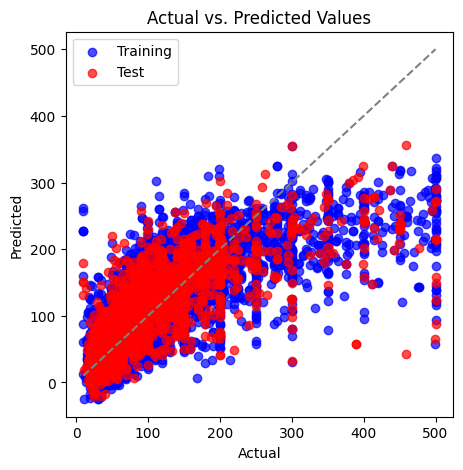

In [145]:
y_pred_train = ridge_reg.predict(X_train_wo_clean_text)
y_pred_test = ridge_reg.predict(X_test_wo_clean_text)
y = train_data_sample['price']

plt.figure(figsize=(5,5))
# Create a scatter plot
plt.scatter(y_train, y_pred_train, label='Training', color='blue', alpha=0.7)
plt.scatter(y_test, y_pred_test, label='Test', color='red', alpha=0.7)

# Add a reference line (ideal fit)

plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()

plt.show()

#### 8.1.3 Random Forest

In [146]:
## Random Forest

rf = RandomForestRegressor(n_estimators=1000, max_depth = None, max_samples = 0.1, random_state=111, verbose=0, n_jobs=10)
rf.fit(X_train_wo_clean_text, y_train)

prediction = pd.DataFrame({"Prediction": rf.predict(X_test_wo_clean_text), "Actual": y_test})

print(f"R2: {rf.score(X_test_wo_clean_text, y_test)}")
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"RMSE: {np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

MAE_dict['random_forest'] = mean_absolute_error(prediction.Actual, prediction.Prediction)
RMSE_dict['random_forest'] = np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))

R2: 0.5442538981087764
MSE: 3227.3258415106106
RMSE: 56.80955765987454
MAE: 35.33423916666666


#### 8.1.4 XGBoost

In [147]:
## XGBoost

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth=2, n_estimators = 600, alpha=20) # also ap adding L2 for regularization
xg_reg.fit(X_train_wo_clean_text, y_train)

prediction = pd.DataFrame({"Prediction": xg_reg.predict(X_test_wo_clean_text), "Actual": y_test})

print(f"R2: {xg_reg.score(X_test_wo_clean_text, y_test)}")
print(f"MSE: {mean_squared_error(prediction.Actual, prediction.Prediction)}")
print(f"RMSE: {np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

MAE_dict['xgboost'] = mean_absolute_error(prediction.Actual, prediction.Prediction)
RMSE_dict['xgboost'] = np.sqrt(mean_squared_error(prediction.Actual, prediction.Prediction))

R2: 0.5652467127406452
MSE: 3078.6670754425627
RMSE: 55.48573758582076
MAE: 34.250279591172934


So far within the benchmark models we see that considering MAE, XGBoost is the performing one.
Also they seem to be already giving quite promising results.
Moving forward we decided to go with both RMSE and MAE as loss functions.
While MAE is a robust loss function to compare different models, RMSE allows us to compare models based on the same magnitude of the target variable.


### 8.2 NLP + Neural Networks

We still start by implementing FNNs. We do not expect much performance from here however as they are trained rather faster compared to RNNs as they lack backward propagation, it is also easier to play around with Hyperparameters and investigate the relationship of textual features to target variable.

#### 8.2.1 Basic FNN

Keras offer you two "styles" of setting up the structure of your network (they call it two types of model): sequential and functional API (https://keras.io/models/about-keras-mod).
We will use functional API modules in the next sections to build layers.

In [151]:
## building FNN with all clean text
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)
flattened_embeddings = layers.Flatten()(text_embeddings)


dense_text = Dense(1, activation="relu")(flattened_embeddings)

# Concatenate
concat = concatenate([dense_text, input_nontext])

layer1 = layers.Dense(512,  activation='relu', #activation function
                kernel_initializer=keras.initializers.he_normal(seed=42), #initialisation of weights, 
                bias_initializer='zeros')(concat)
layer2 = layers.Dense(256,activation='relu',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer1)
predictions = layers.Dense(1, activation='linear')(layer2)

fnn = Model(inputs=[input_text, input_nontext], outputs = predictions)
fnn.summary()

fnn.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

story = fnn.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256, 
                  validation_split=0.2) # keeping the epochs smaller for the case of fast testing and batch size bigger

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 923)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 923, 100)     2670600     ['input_7[0][0]']                
                                                                                                  
 flatten_3 (Flatten)            (None, 92300)        0           ['embedding_3[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 1)            92301       ['flatten_3[0][0]']              
                                                                                              

2023-08-25 18:26:14.210466: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 2s 47ms/step - loss: 25460.4727 - mae: 25461.1621 - mse: 2013440512.0000 - root_mean_squared_error: 44871.3789 - msle: 20.2938 - val_loss: 9051.5908 - val_mae: 9052.2852 - val_mse: 82101208.0000 - val_root_mean_squared_error: 9060.9717 - val_msle: 23.0388
Epoch 2/8
25/25 [==============================] - 1s 45ms/step - loss: 20195.8848 - mae: 20196.5781 - mse: 578417856.0000 - root_mean_squared_error: 24050.3184 - msle: 24.5478 - val_loss: 40680.2461 - val_mae: 40680.9375 - val_mse: 1658041472.0000 - val_root_mean_squared_error: 40719.0547 - val_msle: 39.4207
Epoch 3/8
25/25 [==============================] - 1s 51ms/step - loss: 10548.8936 - mae: 10549.5889 - mse: 190635296.0000 - root_mean_squared_error: 13807.0742 - msle: 20.6630 - val_loss: 11784.4287 - val_mae: 11785.1221 - val_mse: 139153840.0000 - val_root_mean_squared_error: 11796.3486 - val_msle: 19.6268
Epoch 4/8
25/25 [==============================] - 1s 42ms/step - loss: 14949.2686

In [152]:
tr_all_text_pad.shape, X_train_wo_clean_text.shape, y_train.shape

((8000, 923), (8000, 198), (8000,))

In [153]:
eval = fnn.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
# Let's compare different fnn hyperparameter tuned options by collecting them in a dictionary
fnn_hyper_para_dict = {}
fnn_hyper_para_dict['simple_fnn_rmse'] = eval[3]
MAE_dict['simple_fnn'] = eval[1]
RMSE_dict['simple_fnn'] = eval[3]

63/63 [==============================] - 0s 3ms/step - loss: 681.4832 - mae: 682.1762 - mse: 472739.4688 - root_mean_squared_error: 687.5605 - msle: 5.5876


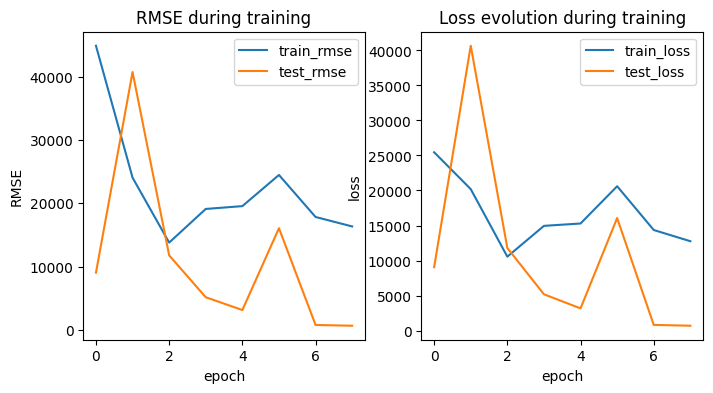

In [154]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

We can see that basic FNN is very poorly performing

#### 8.2.1.1 Hyperparameter tuning

- Number of Hidden Layers and Neurons
- Optimizer: One of the hyperparameter we can change is the optimizer. There are many options SGD, Rmsprop, Adagrad, Adam. Generally Adam is a good default starting point.
- Learning Rate
- Batch Size
- Epochs
- Dropouts
- Momentum - for SGD (beta1 and beta2 for Adam)
- Early stopping rules

We will play around with some of the hyperparameters during the assignment, however will not go deep in to this.

##### Nr of Hidden Layers and Neurons

In [155]:
## building FNN with all clean text with added hidden layers and neurons

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)
flattened_embeddings = layers.Flatten()(text_embeddings)


dense_text = Dense(1, activation="relu")(flattened_embeddings)

# Concatenate
concat = concatenate([dense_text, input_nontext])

layer1 = layers.Dense(1024,  activation='relu', # changed the neuron size
                kernel_initializer=keras.initializers.he_normal(seed=42), #initialisation of weights, 
                bias_initializer='zeros')(concat)
layer2 = layers.Dense(512,activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer1)
layer3 = layers.Dense(256,activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer2)
layer4 = layers.Dense(128,activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer3)
predictions = layers.Dense(1, activation='linear')(layer4)


fnn_1 = Model(inputs=[input_text, input_nontext], outputs = predictions)
fnn_1.summary()
fnn_1.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle']) 
# we are using adam as optimizer, whic provides adaptive learning rate so we do not need to adjust this parameter

story = fnn_1.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256, 
                  validation_split=0.2) # keeping the epochs smaller for the case of fast testing and batch size bigger

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 923)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 923, 100)     2670600     ['input_9[0][0]']                
                                                                                                  
 flatten_4 (Flatten)            (None, 92300)        0           ['embedding_4[0][0]']            
                                                                                                  
 dense_7 (Dense)                (None, 1)            92301       ['flatten_4[0][0]']              
                                                                                            

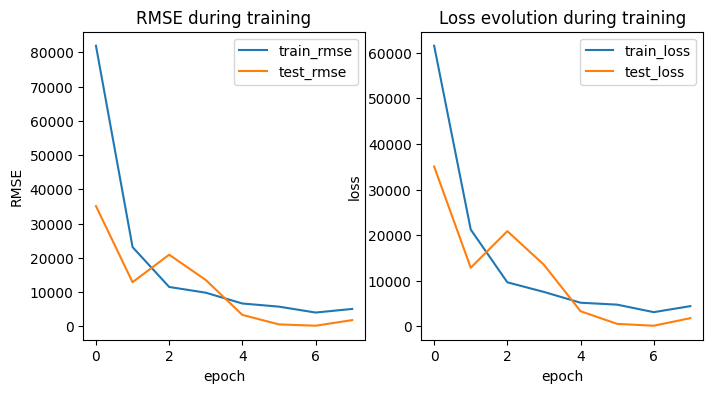

In [156]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

We already see much better performance for fit in test data when we increase layers and neurons

In [157]:
eval = fnn_1.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
fnn_hyper_para_dict['fnn_hiddenlayer+neurons_rmse'] = eval[3]

63/63 [==============================] - 0s 3ms/step - loss: 1792.3945 - mae: 1793.0876 - mse: 3225243.7500 - root_mean_squared_error: 1795.8964 - msle: 10.3215


##### Dropout

In [158]:
## Lets add dropout against overfitting

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)
flattened_embeddings = layers.Flatten()(text_embeddings)


dense_text = Dense(1, activation="relu")(flattened_embeddings)

# Concatenate
concat = concatenate([dense_text, input_nontext])

layer1 = layers.Dense(512,  activation='relu', #activation function
                kernel_initializer=keras.initializers.he_normal(seed=42), #initialisation of weights, 
                bias_initializer='zeros')(concat)
layer1_d = Dropout(0.3)(layer1)  # Adding dropout with a rate of 0.3
layer2 = layers.Dense(256,activation='relu',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer1_d)
layer2_d = Dropout(0.1)(layer2)  # Adding dropout with a rate of 0.2
predictions = layers.Dense(1, activation='linear')(layer2)

fnn_2 = Model(inputs=[input_text, input_nontext], outputs = predictions)
fnn_2.summary()


fnn_2.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

story = fnn_2.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256, 
                  validation_split=0.2) # keeping the epochs smaller for the case of fast testing and batch size bigger

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 923, 100)     2670600     ['input_11[0][0]']               
                                                                                                  
 flatten_5 (Flatten)            (None, 92300)        0           ['embedding_5[0][0]']            
                                                                                                  
 dense_13 (Dense)               (None, 1)            92301       ['flatten_5[0][0]']              
                                                                                            

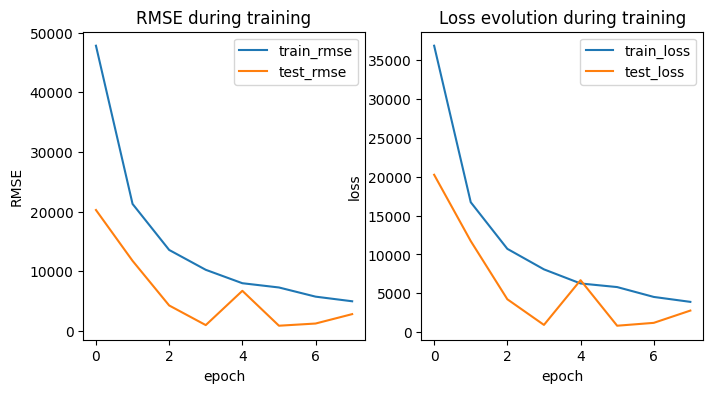

In [159]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

In [160]:
eval = fnn_2.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
fnn_hyper_para_dict['fnn_dropout'] = eval[3]

63/63 [==============================] - 0s 3ms/step - loss: 2797.1924 - mae: 2797.8862 - mse: 7842582.5000 - root_mean_squared_error: 2800.4612 - msle: 19.9862


##### Changing Epochs and Batch Size

In [161]:
## Lets increase epochs

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)
flattened_embeddings = layers.Flatten()(text_embeddings)


dense_text = Dense(1, activation="relu")(flattened_embeddings)

# Concatenate
concat = concatenate([dense_text, input_nontext])

layer1 = layers.Dense(512,  activation='relu', #activation function
                kernel_initializer=keras.initializers.he_normal(seed=42), #initialisation of weights, 
                bias_initializer='zeros')(concat)
layer1_d = Dropout(0.3)(layer1)  # Adding dropout with a rate of 0.3
layer2 = layers.Dense(256,activation='relu',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer1_d)
layer2_d = Dropout(0.1)(layer2)  # Adding dropout with a rate of 0.2
predictions = layers.Dense(1, activation='linear')(layer2)

fnn_3 = Model(inputs=[input_text, input_nontext], outputs = predictions)
fnn_3.summary()

fnn_3.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

story = fnn_3.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=16, verbose=1, batch_size=128,  # lets double the epochs and half the batch size
                  validation_split=0.2)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 923, 100)     2670600     ['input_13[0][0]']               
                                                                                                  
 flatten_6 (Flatten)            (None, 92300)        0           ['embedding_6[0][0]']            
                                                                                                  
 dense_17 (Dense)               (None, 1)            92301       ['flatten_6[0][0]']              
                                                                                            

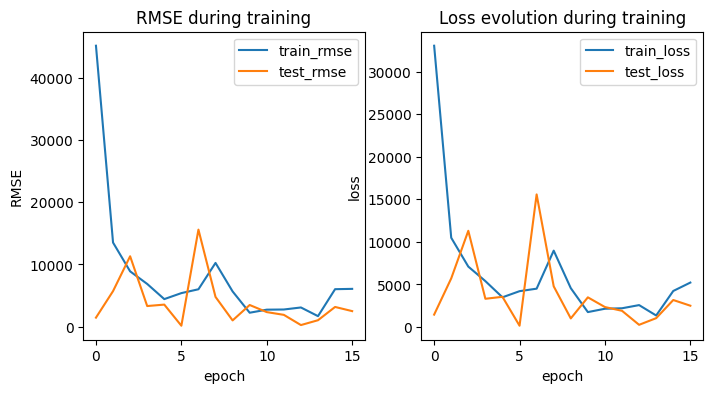

In [162]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

In [163]:
eval = fnn_3.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
fnn_hyper_para_dict['fnn_epochs_batchsize'] = eval[3]

63/63 [==============================] - 0s 3ms/step - loss: 2503.1289 - mae: 2503.8220 - mse: 6282265.0000 - root_mean_squared_error: 2506.4446 - msle: 12.4129


Decreasing the Batch size can have an effect of regularization on the model. However smaller batches may result in slower training.
Increasing Epochs can yield to better performance but also in the long end can lead to overfitting. I think we observe this in our graph already.

##### Early Stopping Rules

In [164]:
# Lets add early stopping rules
input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)
flattened_embeddings = layers.Flatten()(text_embeddings)


dense_text = Dense(1, activation="relu")(flattened_embeddings)

# Concatenate
concat = concatenate([dense_text, input_nontext])

layer1 = layers.Dense(512,  activation='relu', #activation function
                kernel_initializer=keras.initializers.he_normal(seed=42), #initialisation of weights, 
                bias_initializer='zeros')(concat)
layer2 = layers.Dense(256,activation='relu',kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer1)
predictions = layers.Dense(1, activation='linear')(layer2)

fnn_4 = Model(inputs=[input_text, input_nontext], outputs = predictions)
fnn_4.summary()

fnn_4.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])
fnn_4.summary()

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = fnn_4.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256, 
                  validation_split=0.2, callbacks=callbacks)  # adding early stopping rules


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 923, 100)     2670600     ['input_15[0][0]']               
                                                                                                  
 flatten_7 (Flatten)            (None, 92300)        0           ['embedding_7[0][0]']            
                                                                                                  
 dense_21 (Dense)               (None, 1)            92301       ['flatten_7[0][0]']              
                                                                                            

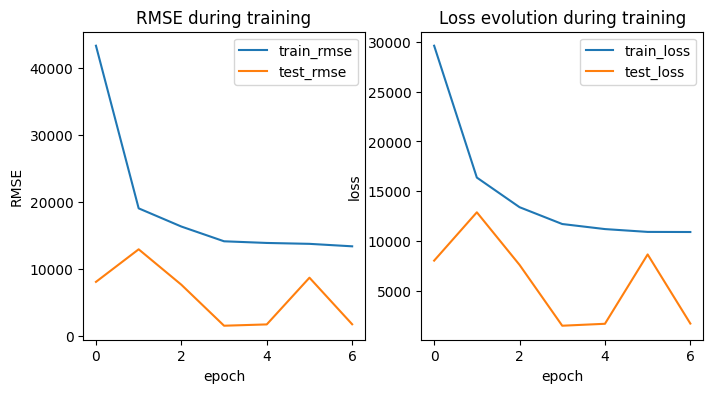

In [165]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

In [166]:
eval = fnn_4.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
fnn_hyper_para_dict['fnn_earlystopping'] = eval[3]

63/63 [==============================] - 0s 4ms/step - loss: 1493.0377 - mae: 1493.7311 - mse: 2240130.7500 - root_mean_squared_error: 1496.7067 - msle: 9.2775


<ins>Comparing FNN Hyperparameter Tuning Options<ins>



In [167]:
fnn_hyper_para_dict

{'simple_fnn_rmse': 687.560546875,
 'fnn_hiddenlayer+neurons_rmse': 1795.8963623046875,
 'fnn_dropout': 2800.461181640625,
 'fnn_epochs_batchsize': 2506.444580078125,
 'fnn_earlystopping': 1496.7066650390625}

<ins>Comparing Results of Hyperparameter Tuning:<ins>

We have seen surprising results where Hyperparameter runing did not return better results, neither increasing epochs or others. 
We will investigate this further.

#### 8.2.2 FNN Final

In [168]:
# Lets add early stopping rules
input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)
flattened_embeddings = layers.Flatten()(text_embeddings)


dense_text = Dense(1, activation="relu")(flattened_embeddings)

# Concatenate
concat = concatenate([dense_text, input_nontext])

layer1 = layers.Dense(1024,  activation='relu', # changed the neuron size
                kernel_initializer=keras.initializers.he_normal(seed=42), #initialisation of weights, 
                bias_initializer='zeros')(concat)
layer1_d = Dropout(0.3)(layer1)
layer2 = layers.Dense(512,activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer1_d)
layer3 = layers.Dense(256,activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer2)
layer3_d = Dropout(0.1)(layer3)
layer4 = layers.Dense(128,activation='relu',
                      kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')(layer3)
predictions = layers.Dense(1, activation='linear')(layer4)

fnn_final = Model(inputs=[input_text, input_nontext], outputs = predictions)

fnn_final.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])
fnn_final.summary()

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = fnn_final.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=16, verbose=1, batch_size=256, 
                  validation_split=0.2, callbacks=callbacks)


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 923, 100)     2670600     ['input_17[0][0]']               
                                                                                                  
 flatten_8 (Flatten)            (None, 92300)        0           ['embedding_8[0][0]']            
                                                                                                  
 dense_25 (Dense)               (None, 1)            92301       ['flatten_8[0][0]']              
                                                                                            

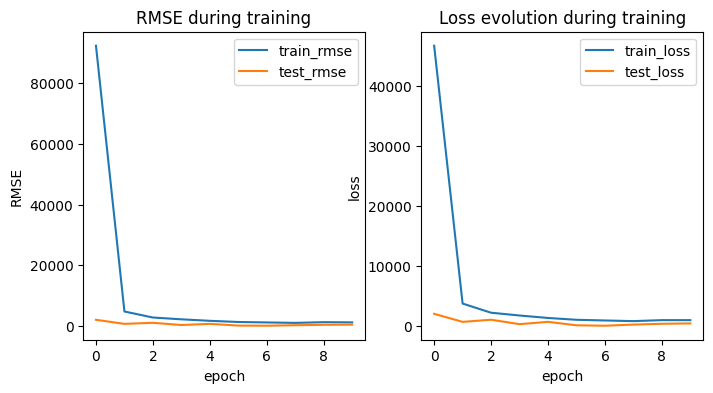

In [169]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

In [170]:
eval = fnn_final.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
fnn_hyper_para_dict['fnn_final'] = eval[3]

63/63 [==============================] - 0s 3ms/step - loss: 61.9778 - mae: 62.6678 - mse: 9780.2324 - root_mean_squared_error: 98.8951 - msle: 0.6757


In [171]:
fnn_hyper_para_dict

{'simple_fnn_rmse': 687.560546875,
 'fnn_hiddenlayer+neurons_rmse': 1795.8963623046875,
 'fnn_dropout': 2800.461181640625,
 'fnn_epochs_batchsize': 2506.444580078125,
 'fnn_earlystopping': 1496.7066650390625,
 'fnn_final': 98.89505767822266}

##### !!! However the final FNN with all hyperparameters returned better results than individual ones.

In [172]:
MAE_dict['fnn_final'] = eval[1]
RMSE_dict['fnn_final'] = eval[3]

### 8.3 RNN Architecture

Here after investigating different FNN parameters, we are actually going in to RNNs where we expect to pick the final model.
Considering the nature of our text features also the fact that we stacked them together, and since we are dealing with predefined sequences unlike sequantial data such as timeseries it might make more sense to actually use Bi-directional RNN methods. However we will see in the following section their performance.

For RNNs: The number of hidden units in the GRUs is chosen to be 100, and the final activation functions are set to ReLU, since price can not be negative.
Also we are using adam as adaptive optimizer as it is default to use.
Also as we have rather long sequences due to stacking and as we use the max_text_length for the shape of our input_text they will be a lof of zeros which might affect out predictive power. Thus we will also add mask_zero = True and trainable = True for our Embedding layer.

#### 8.3.1 Simple GRU

In [174]:
## building Simple GRU with all clean text

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)
## HERE we implement GRU
GRU_text = GRU(100)(text_embeddings)

# we do not need the flattening layer. The expected input structure of RNN-type layers is a 3D tensor of dimensions: batch size, Features, Sequence length
#This is exactly the same data structure that the Embedding layer produces. 

dense_text = Dense(1, activation="relu")(GRU_text)

# Concatenate
concat = concatenate([dense_text, input_nontext])

# Add Layers
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full) # as the final output is a price we use linear activation in output layer

gru = Model(inputs=[input_text, input_nontext], outputs = output_layer)

gru.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

print(gru.summary())

story = gru.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 923, 100)     2670600     ['input_21[0][0]']               
                                                                                                  
 gru_1 (GRU)                    (None, 100)          60600       ['embedding_10[0][0]']           
                                                                                                  
 dense_36 (Dense)               (None, 1)            101         ['gru_1[0][0]']                  
                                                                                            

In [175]:
eval = gru.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
MAE_dict['gru'] = eval[1]
RMSE_dict['gru'] = eval[3]

63/63 [==============================] - 10s 152ms/step - loss: 684.3003 - mae: 684.9933 - mse: 476694.0625 - root_mean_squared_error: 690.4304 - msle: 5.6047


#### 8.3.2 GRU with Glove
Downloading the Glove Embeddings from: https://nlp.stanford.edu/projects/glove/
Using this article for now: https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

In [176]:
# Load GloVe embeddings
# Set the variable to the GLOVE embeddings file on your hard disk. 

glove_index = {}
start = time.time()
i = 0
with open('data/glove6B/glove.6B.100d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs
        i += 1
        #if i % 50000 == 0:
            #print('Read {} lines of embeddings in {} sec.'.format(i, time.time()-start))

print('Found {} word vectors after {} sec.'.format(len(glove_index), time.time()-start))

Found 400000 word vectors after 4.70719575881958 sec.


In [177]:
# Create matrix with Glove embeddings
# Caution: this operation may take a long time and consume a lot of memory
glove_weights_all_text, _ = get_embedding_matrix(tokenizer_all_text, glove_index, NUM_WORDS_ALL_TEXT)

Start embedding process for 26705 words.
Created embedding matrix of shape (26706, 100) in 0.0010013620058695475 min 
Encountered 13261 out-of-vocabulary words.


##### !!! With glove we see even higher number of out-of-vocabulary words.

In [178]:
## building GRU with GLove Embeddings with all clean text

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100, input_length=923,
                       embeddings_initializer=Constant(glove_weights_all_text), ## HERE we implement glove weights
                       trainable=True, mask_zero=True)(input_text)

GRU_text = GRU(100)(text_embeddings)

dense_text = Dense(1, activation="relu")(GRU_text)

# Concatenate
concat = concatenate([dense_text, input_nontext])

# Add Layers
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full) # as the final output is a price we use linear activation in output layer

gru_glove = Model(inputs=[input_text, input_nontext], outputs = output_layer)

gru_glove.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

print(gru_glove.summary())

story = gru_glove.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, 923, 100)     2670600     ['input_23[0][0]']               
                                                                                                  
 gru_2 (GRU)                    (None, 100)          60600       ['embedding_11[0][0]']           
                                                                                                  
 dense_41 (Dense)               (None, 1)            101         ['gru_2[0][0]']                  
                                                                                            

In [179]:
eval = gru_glove.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
MAE_dict['gru_glove'] = eval[1]
RMSE_dict['gru_glove'] = eval[3]

63/63 [==============================] - 10s 143ms/step - loss: 4204.7861 - mae: 4205.4795 - mse: 17710672.0000 - root_mean_squared_error: 4208.4048 - msle: 16.1266


#### 8.3.3 Bi-directional GRU

In [181]:
## building Simple GRU with all clean text

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)

## HERE we implement Bi-directional GRU
Bi_GRU_text = Bidirectional(GRU(100))(text_embeddings)

dense_text = Dense(1, activation="relu")(Bi_GRU_text)

# Concatenate
concat = concatenate([dense_text, input_nontext])

# Add Layers
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full) # as the final output is a price we use linear activation in output layer

bi_gru = Model(inputs=[input_text, input_nontext], outputs = output_layer)

bi_gru.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

print(bi_gru.summary())

story = bi_gru.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256)


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 923, 100)     2670600     ['input_27[0][0]']               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 200)         121200      ['embedding_13[0][0]']           
 )                                                                                                
                                                                                                  
 dense_51 (Dense)               (None, 1)            201         ['bidirectional_1[0][0]'] 

In [182]:
eval = bi_gru.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
MAE_dict['bi_gru'] = eval[1]
RMSE_dict['bi_gru'] = eval[3]

63/63 [==============================] - 9s 128ms/step - loss: 673.2990 - mae: 673.9921 - mse: 461700.0625 - root_mean_squared_error: 679.4852 - msle: 19.9861


#### 8.3.4 LSTM

In [183]:
## building LSTM with all clean text

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)

## HERE we implement LSTM
LSTM_text = LSTM(100, return_sequences=False)(text_embeddings) 
dense_text = Dense(1, activation="relu")(LSTM_text)

# Concatenate
concat = concatenate([dense_text, input_nontext])

# Add Layers
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full) # as the final output is a price we use linear activation in output layer

lstm = Model(inputs=[input_text, input_nontext], outputs = output_layer)

lstm.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

print(lstm.summary())

story = lstm.fit([tr_all_text_pad, X_train_wo_clean_text], y_train,
                 epochs=8, verbose=1, batch_size=256, validation_split=0.2)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 923, 100)     2670600     ['input_29[0][0]']               
                                                                                                  
 lstm (LSTM)                    (None, 100)          80400       ['embedding_14[0][0]']           
                                                                                                  
 dense_56 (Dense)               (None, 1)            101         ['lstm[0][0]']                   
                                                                                           

In [188]:
preds = pd.DataFrame(lstm.predict([ts_all_text_pad, X_test_wo_clean_text]), columns=["pred"], index=X_test.index)
preds["actual"] = y_test

63/63 [==============================] - 7s 117ms/step


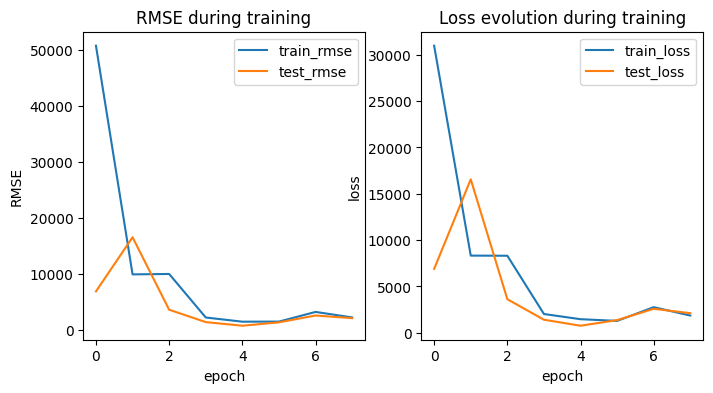

In [189]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

In [190]:
eval = lstm.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
MAE_dict['lstm'] = eval[1]
RMSE_dict['lstm'] = eval[3]

63/63 [==============================] - 8s 121ms/step - loss: 2123.3652 - mae: 2124.0579 - mse: 4523124.0000 - root_mean_squared_error: 2126.7637 - msle: 19.9861


#### 8.3.5 Bi-directional LSTM

In [191]:
## building LSTM with all clean text

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)

bi_LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings) # Setting up Birectional LSTM here

dense_text = Dense(1, activation="relu")(bi_LSTM_text)

# Concatenate
concat = concatenate([dense_text, input_nontext])

# Add Layers
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full) # as the final output is a price we use linear activation in output layer

bi_lstm = Model(inputs=[input_text, input_nontext], outputs = output_layer)

bi_lstm.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

print(lstm.summary())

story = bi_lstm.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 923, 100)     2670600     ['input_29[0][0]']               
                                                                                                  
 lstm (LSTM)                    (None, 100)          80400       ['embedding_14[0][0]']           
                                                                                                  
 dense_56 (Dense)               (None, 1)            101         ['lstm[0][0]']                   
                                                                                           

In [197]:
eval = bi_lstm.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
MAE_dict['bi_lstm'] = eval[1]
RMSE_dict['bi_lstm'] = eval[3]

63/63 [==============================] - 12s 190ms/step - loss: 64.0385 - mae: 64.7252 - mse: 10314.1309 - root_mean_squared_error: 101.5585 - msle: 0.7647


#### 8.3.6 Deep LSTM

In [193]:
## building LSTM with all clean text

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)

LSTM_text_1 = LSTM(100, return_sequences=True)(text_embeddings)
LSTM_text_2 = LSTM(50, return_sequences=False)(LSTM_text_1) # we are placing LSTM layer in to another LSTM layer for building deeper LSTM
dense_text = Dense(1, activation="relu")(LSTM_text_2)

# Concatenate
concat = concatenate([dense_text, input_nontext])

# Add Layers
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full) # as the final output is a price we use linear activation in output layer

lstm_deep = Model(inputs=[input_text, input_nontext], outputs = output_layer)

lstm_deep.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

print(lstm_deep.summary())

story = lstm_deep.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 923, 100)     2670600     ['input_35[0][0]']               
                                                                                                  
 lstm_3 (LSTM)                  (None, 923, 100)     80400       ['embedding_17[0][0]']           
                                                                                                  
 lstm_4 (LSTM)                  (None, 50)           30200       ['lstm_3[0][0]']                 
                                                                                           

In [194]:
eval = lstm_deep.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
MAE_dict['lstm_deep'] = eval[1]
RMSE_dict['lstm_deep'] = eval[3]

63/63 [==============================] - 15s 220ms/step - loss: 1379.0806 - mae: 1379.7737 - mse: 1912570.3750 - root_mean_squared_error: 1382.9572 - msle: 8.8451


### 8.4 Commentary on the model comparison

In [195]:
## Comparing the models so far.
pd.set_option('display.max_columns', None)  
pd.DataFrame([MAE_dict])

,linear_reg,ridge_reg,random_forest,xgboost,simple_fnn,fnn_final,gru,gru_glove,bi_gru,lstm,bi_lstm,lstm_deep
0,36.845781,36.596429,35.334239,34.25028,682.176208,62.667816,684.993286,4205.479492,673.992126,2124.057861,64.725235,1379.773682


In [196]:
pd.DataFrame([RMSE_dict])

,linear_reg,ridge_reg,random_forest,xgboost,simple_fnn,fnn_final,gru,gru_glove,bi_gru,lstm,bi_lstm,lstm_deep
0,57.353801,57.166762,56.809558,55.485738,687.560547,98.895058,690.430359,4208.404785,679.485168,2126.763672,101.55851,1382.957153


We can already see that XGBoost model which is our Benchmark model performs the best so far.
I think this is due to NN models putting more than necessary importance to Text Feature where as actually already the tabular data features in the regression problem are strong indicator of the price. 

For the NN models, we observe that Bi-directional LSTM returns the best result, followed by FNN-FInal and GRU. We can try couple of options to increase the model performance of these models. 
1. We can apply hyperparameter tuning that tried before for the best performing model.
2. Stacking Benchmark Model and NN Model for textual features together: XGBoost + Bi-directional LSTM
3. Using text columns not stacked but one by one
4. Using amenities feature not as one-hot-encoded but as embedding.

### 8.5 Adding Hyperparameter Tuning to Picked Model

In [201]:
## building bi-LSTM hyperparameters

input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)

bi_LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings) # Setting up Birectional LSTM here
dense_text = Dense(1, activation="relu")(bi_LSTM_text)

# Concatenate
concat = concatenate([dense_text, input_nontext])

# Add Layers
dense_full = Dense(2048,kernel_regularizer='l2' ,activation='relu')(concat) #increasing number of layers and neurons and implementing l2 regularization
dense_full = Dense(1024,kernel_regularizer='l2' ,activation='relu')(dense_full)
dense_full = Dense(512,kernel_regularizer='l2' ,activation='relu')(dense_full)
dense_full = Dense(128,kernel_regularizer='l2' ,activation='relu')(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

bi_LSTM_final = Model(inputs=[input_text, input_nontext], outputs = output_layer)

bi_LSTM_final.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])
bi_LSTM_final.summary()

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = bi_LSTM_final.fit([tr_all_text_pad, X_train_wo_clean_text], 
                  y_train, epochs=16, verbose=1, batch_size=256, 
                  validation_split=0.2, callbacks=callbacks)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 923, 100)     2670600     ['input_41[0][0]']               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 200)         160800      ['embedding_20[0][0]']           
 )                                                                                                
                                                                                                  
 dense_88 (Dense)               (None, 1)            201         ['bidirectional_6[0][0]'] 

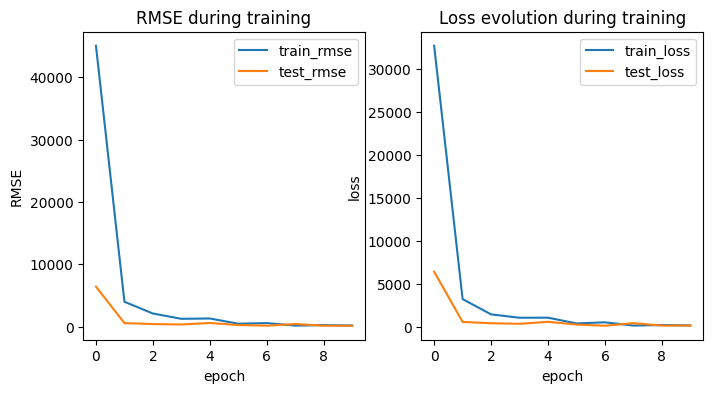

In [199]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    ax1.plot(story.history['root_mean_squared_error'])
    ax1.plot(story.history['val_root_mean_squared_error'])
    ax1.set(xlabel='epoch', ylabel='RMSE')
    ax1.legend(['train_rmse', 'test_rmse'], loc='best')
    ax1.set_title('RMSE during training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during training')
    plt.show()

show_history(story)

In [206]:
eval = bi_LSTM_final.evaluate([ts_all_text_pad, X_test_wo_clean_text], y_test)
MAE_dict['bi_LSTM_final'] = eval[1]
RMSE_dict['bi_LSTM_final'] = eval[3]

63/63 [==============================] - 13s 199ms/step - loss: 64.3115 - mae: 57.3365 - mse: 7871.3408 - root_mean_squared_error: 88.7206 - msle: 0.5313


### 8.6 Stacked Model Approach

As the XGBoost was performing so well, why not stack XGBoost ensemble learning algorithm by using the tabular data and train a NN for textual features and stack the predictions.

In [207]:
# Stacking both model: BiLSTM and XGBoost

## XGBoost

xgb_stack = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth=2, n_estimators = 600, alpha=20) # also ap adding L2 for regularization
xgb_stack.fit(X_train_wo_clean_text, y_train)

xgb_stack_preds = xgb_stack.predict(X_test_wo_clean_text)

input_text = Input(shape=(923, ))

# Bi-LSTM

# Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)

bi_LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings) # Setting up Birectional LSTM here
dense_text = Dense(1, activation="relu")(bi_LSTM_text)

# Concatenate
#concat = concatenate([dense_text])

# Add Layers
dense_full = Dense(2048,kernel_regularizer='l2' ,activation='relu')(dense_text) #increasing number of layers and neurons and implementing l2 regularization
dense_full = Dense(1024,kernel_regularizer='l2' ,activation='relu')(dense_full)
dense_full = Dense(512,kernel_regularizer='l2' ,activation='relu')(dense_full)
dense_full = Dense(128,kernel_regularizer='l2' ,activation='relu')(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

bi_LSTM_stack = Model(inputs=input_text, outputs = output_layer)

bi_LSTM_stack.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])
bi_LSTM_stack.summary()

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = bi_LSTM_stack.fit(tr_all_text_pad, 
                  y_train, epochs=16, verbose=1, batch_size=256, 
                  validation_split=0.2, callbacks=callbacks)

bi_LSTM_stack_preds = bi_LSTM_stack.predict(ts_all_text_pad)

# Reshape GRU predictions
bi_LSTM_stack_preds = np.squeeze(bi_LSTM_stack_preds)

# Create new dataset with predictions from both models
xgb_combined_train = np.column_stack((bi_LSTM_stack_preds, xgb_stack_preds))

# Train a meta-model (XGBoost) on the training set
meta_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth=16, n_estimators = 600, alpha=20) # also ap adding L2 for regularization

meta_model.fit(xgb_combined_train, y_test)

# Generate stacked predictions for the validation set
stacked_preds_val = meta_model.predict(xgb_combined_train)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 923)]             0         
                                                                 
 embedding_22 (Embedding)    (None, 923, 100)          2670600   
                                                                 
 bidirectional_8 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_100 (Dense)           (None, 1)                 201       
                                                                 
 dense_101 (Dense)           (None, 2048)              4096      
                                                                 
 dense_102 (Dense)           (None, 1024)              2098176   
                                                          

In [208]:
# Evaluate the stacked model's performance
print(f"MSE: {mean_squared_error(y_test, stacked_preds_val)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, stacked_preds_val))}")
print(f"MAE: {mean_absolute_error(y_test, stacked_preds_val)}")

MSE: 154.53600911037083
RMSE: 12.431251309114897
MAE: 9.776708310127258


In [209]:
MAE_dict['xgb_biLSTM_stacked'] = mean_absolute_error(y_test, stacked_preds_val)
RMSE_dict['xgb_biLSTM_stacked'] = np.sqrt(mean_squared_error(y_test, stacked_preds_val))

This is the best performing model so far. We will if needed go with this one.

### 8.7 Model with Separate Embedding Layers for Individual Text Features

Before we have stacked all the texttual features in to one feature and created embeddings on this feature as `clean_all_text` and trained our model on this.
However we have also discussed to treat them separately and observe how this would impact the model.
For this reason before we created the following dictionaries for each of the individual text features:
1. tr_embedding_weights_dic
2. tr_padded_text_dict
3. num_words_dict
4. max_text_length_dic\
Following we will use these dictionaries to build individual embedding layers and concat. We will use LSTM for this and compare with LSTM results above.

In [212]:
## this is a try to build based on separate input text columns
# We are keeping the rest of the features equal with bi_LSTM to compare end model evaluations
input_nontext = Input(shape=(198, ))

# Text name
input_text_name = Input(shape=(max_text_length_dic['clean_name'], ))
name_embeddings = Embedding(num_words_dict['clean_name'], output_dim=100,
                     embeddings_initializer=Constant(tr_embedding_weights_dic['clean_name']),
                     input_length=max_text_length_dic['clean_name'], trainable=True, mask_zero=True)(input_text_name)

bi_LSTM_name = Bidirectional(LSTM(100, return_sequences=False))(name_embeddings)
dense_name = Dense(1, activation="relu")(bi_LSTM_name)

# Text space
input_text_space = Input(shape=(max_text_length_dic['clean_space'], ))
space_embeddings = Embedding(num_words_dict['clean_space'], output_dim=100,
                     embeddings_initializer=Constant(tr_embedding_weights_dic['clean_space']),
                     input_length=max_text_length_dic['clean_space'], trainable=True, mask_zero=True)(input_text_space)

bi_LSTM_space = Bidirectional(LSTM(100, return_sequences=False))(space_embeddings)
dense_space = Dense(1, activation="relu")(bi_LSTM_space)

# Text description
input_text_desc = Input(shape=(max_text_length_dic['clean_description'], ))
desc_embeddings = Embedding(num_words_dict['clean_description'], output_dim=100,
                     embeddings_initializer=Constant(tr_embedding_weights_dic['clean_description']),
                     input_length=max_text_length_dic['clean_description'], trainable=True, mask_zero=True)(input_text_desc)

bi_LSTM_desc = Bidirectional(LSTM(100, return_sequences=False))(desc_embeddings)
dense_desc = Dense(1, activation="relu")(bi_LSTM_desc)

# Text neighborhood_overview
input_text_neigh_ovrvw = Input(shape=(max_text_length_dic['clean_neighborhood_overview'], ))
neighbourhood_overview_embeddings = Embedding(num_words_dict['clean_neighborhood_overview'], output_dim=100,
                     embeddings_initializer=Constant(tr_embedding_weights_dic['clean_neighborhood_overview']),
                     input_length=max_text_length_dic['clean_neighborhood_overview'], trainable=True, mask_zero=True)(input_text_neigh_ovrvw)

bi_LSTM_neigh_ovrvw = Bidirectional(LSTM(100, return_sequences=False))(neighbourhood_overview_embeddings)
dense_neigh_ovrvw = Dense(1, activation="relu")(bi_LSTM_neigh_ovrvw)

# Text transit
input_text_transit = Input(shape=(max_text_length_dic['clean_transit'], ))
transit_embeddings = Embedding(num_words_dict['clean_transit'], output_dim=100,
                     embeddings_initializer=Constant(tr_embedding_weights_dic['clean_transit']),
                     input_length=max_text_length_dic['clean_transit'], trainable=True, mask_zero=True)(input_text_transit)

bi_LSTM_transit = Bidirectional(LSTM(100, return_sequences=False))(transit_embeddings)
dense_transit = Dense(1, activation="relu")(bi_LSTM_transit)

# Text house_rules
input_text_house_rules = Input(shape=(max_text_length_dic['clean_house_rules'], ))
house_rules_embeddings = Embedding(num_words_dict['clean_house_rules'], output_dim=100,
                     embeddings_initializer=Constant(tr_embedding_weights_dic['clean_house_rules']),
                     input_length=max_text_length_dic['clean_house_rules'], trainable=True, mask_zero=True)(input_text_house_rules)

bi_LSTM_house_rules = Bidirectional(LSTM(100, return_sequences=False))(house_rules_embeddings)
dense_house_rules = Dense(1, activation="relu")(bi_LSTM_house_rules)

# Concatenate the flattened vectors and input_nontext
concatenated_embeddings = concatenate([dense_name, dense_space, dense_desc, dense_neigh_ovrvw, dense_transit, dense_house_rules])

# Concatenate with non-text features
concat = concatenate([concatenated_embeddings, input_nontext])

# Add Layers
dense_full = Dense(1024, activation="relu")(concat)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

# Create the model
lstm_separate_txt = Model(inputs= [input_text_name, input_text_space, input_text_desc, input_text_neigh_ovrvw, input_text_transit, input_text_house_rules, input_nontext], outputs=output_layer)

# Compile the model
lstm_separate_txt.compile(loss=losses.LogCosh(), optimizer='adam', metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

print(lstm_separate_txt.summary())

# Train the model
story = lstm_separate_txt.fit( [tr_padded_text_dict['clean_name'],
                                tr_padded_text_dict['clean_space'],
                                tr_padded_text_dict['clean_description'],
                                tr_padded_text_dict['clean_neighborhood_overview'],
                                tr_padded_text_dict['clean_transit'],
                                tr_padded_text_dict['clean_house_rules'],
                                X_train_wo_clean_text], y_train,
                              epochs=8, verbose=1, batch_size=256)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_49 (InputLayer)          [(None, 206)]        0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 194)]        0           []                               
                                                                                           

In [213]:
eval = lstm_separate_txt.evaluate([ts_padded_text_dict['clean_name'],
                                    ts_padded_text_dict['clean_space'],
                                    ts_padded_text_dict['clean_description'],
                                    ts_padded_text_dict['clean_neighborhood_overview'],
                                    ts_padded_text_dict['clean_transit'],
                                    ts_padded_text_dict['clean_house_rules'],
                                   X_test_wo_clean_text], y_test)
MAE_dict['bi_lstm_separate_txt'] = eval[1]
RMSE_dict['bi_lstm_separate_txt'] = eval[3]

63/63 [==============================] - 15s 124ms/step - loss: 749.4930 - mae: 750.1860 - mse: 570364.0625 - root_mean_squared_error: 755.2245 - msle: 5.9682


We have observed higher MAE and RMSE values compared to the original BiLSTM model performance. Creating Separate Embedding Layers for each text feature did not add up the the predictive power of the model. Thus we will go with the stacked `clean_all_text` approach.

### 8.8 Working with Amenities column as a Embedding

In [231]:
seed = 42
# for full model
benchmark_model_features_amenities = benchmark_model_features + ['amenities']

X_train, X_test, y_train, y_test = train_test_split(train_data_sample[benchmark_model_features_amenities], train_data_sample['price'], test_size=0.20, random_state=seed)

filter_col_clean_text_amenities = filter_col_clean_text + ['amenities']

# convert all numeric columns to float
X_train_wo_clean_text = np.asarray(X_train.drop(columns=filter_col_clean_text_amenities)).astype('float32')
X_test_wo_clean_text = np.asarray(X_test.drop(columns=filter_col_clean_text_amenities)).astype('float32')
#X_train_wo_clean_text = np.asarray(X_train.drop(columns='clean_description')).astype('float32')

In [232]:
X_train.dtypes

scaled_host_response_rate           float64
scaled_host_total_listings_count    float64
scaled_review_scores_rating         float64
scaled_accommodates                 float64
scaled_bathrooms                    float64
                                     ...   
clean_neighborhood_overview          object
clean_transit                        object
clean_house_rules                    object
clean_all_text_features              object
amenities                            object
Length: 207, dtype: object

In [233]:
# Tokenization and Vocabulary Building
tokenizer = Tokenizer()
tokenizer.fit_on_texts(amenities_text)
amenities_sequences = tokenizer.texts_to_sequences(amenities_text)
amenities_vocab_size = len(tokenizer.word_index) + 1

# Padding
max_amenities_length = max(len(seq) for seq in amenities_sequences)
padded_amenities_sequences = pad_sequences(amenities_sequences, maxlen=max_amenities_length)

In [234]:
#Lets do the same for test data
ts_amenities_text = X_test['amenities'].tolist()
ts_amenities_sequences = tokenizer.texts_to_sequences(ts_amenities_text)

# Padding
ts_padded_amenities_sequences = pad_sequences(ts_amenities_sequences, maxlen=max_amenities_length)

In [238]:
tr_all_text_pad.shape, padded_amenities_sequences.shape ,X_train_wo_clean_text.shape

((8000, 923), (8000, 197), (8000, 198))

In [239]:
# Lets build the model
input_text = Input(shape=(923, ))
input_nontext = Input(shape=(198, ))
input_amenities = Input(shape=(197,))

# Text: Clean_Text
text_embeddings = Embedding(NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(wiki_weights_all_text),
                     input_length=923, trainable=True, mask_zero=True)(input_text)

bi_LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings) # Setting up Birectional LSTM here

dense_text = Dense(1, activation="relu")(bi_LSTM_text)

# Text Amenities
# Define the model
amenities_embedding = Embedding(amenities_vocab_size ,output_dim=100)(input_amenities)

LSTM_amenities_text = LSTM(100, return_sequences=False)(amenities_embedding)

dense_amenities = Dense(1, activation="relu")(LSTM_amenities_text)

# Concatenate
concat = concatenate([dense_text, dense_amenities, input_nontext])
dense_full = Dense(1024,kernel_regularizer='l2' , activation="relu")(concat)
dense_full = Dense(512,kernel_regularizer='l2' , activation="relu")(dense_full)
dense_full = Dense(256,kernel_regularizer='l2' , activation="relu")(dense_full)
output_layer = Dense(1,kernel_regularizer='l2' , activation="linear")(dense_full)

lstm_amenity = Model(inputs=[input_text, input_amenities, input_nontext], outputs = output_layer)

lstm_amenity.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])
lstm_amenity.summary()

callbacks = [EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = lstm_amenity.fit([tr_all_text_pad, padded_amenities_sequences ,X_train_wo_clean_text], 
                  y_train, epochs=8, verbose=1, batch_size=256, 
                  validation_split=0.2, callbacks=callbacks)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 923)]        0           []                               
                                                                                                  
 input_64 (InputLayer)          [(None, 197)]        0           []                               
                                                                                                  
 embedding_35 (Embedding)       (None, 923, 100)     2670600     ['input_62[0][0]']               
                                                                                                  
 embedding_36 (Embedding)       (None, 197, 100)     27700       ['input_64[0][0]']               
                                                                                           

In [241]:
eval = lstm_amenity.evaluate([ts_all_text_pad, ts_padded_amenities_sequences ,X_test_wo_clean_text], y_test)
MAE_dict['bi_lstm_amenity'] = eval[1]
RMSE_dict['bi_lstm_amenity'] = eval[3]

63/63 [==============================] - 15s 244ms/step - loss: 141.8723 - mae: 138.4836 - mse: 26254.5156 - root_mean_squared_error: 162.0325 - msle: 20.0114


#### REMARK:
We observe higher RMSE than original bi-LSTM model. So decreasing cardinality thru embeddings did not work as good as one_hot_encoding for amenities feature.
So we will use it as one-hot-encoded in the final model rather than Embeddings.

### 8.9 Final Comparison Of Models

In [242]:
## Comparing the models so far.
pd.set_option('display.max_columns', None)  
pd.DataFrame([MAE_dict])

,linear_reg,ridge_reg,random_forest,xgboost,simple_fnn,fnn_final,gru,gru_glove,bi_gru,lstm,bi_lstm,lstm_deep,bi_LSTM_final,xgb_biLSTM_stacked,bi_lstm_separate_txt,bi_lstm_amenity
0,36.845781,36.596429,35.334239,34.25028,682.176208,62.667816,684.993286,4205.479492,673.992126,2124.057861,64.725235,1379.773682,57.336498,9.776708,750.186035,138.483582


In [243]:
pd.DataFrame([RMSE_dict])

,linear_reg,ridge_reg,random_forest,xgboost,simple_fnn,fnn_final,gru,gru_glove,bi_gru,lstm,bi_lstm,lstm_deep,bi_LSTM_final,xgb_biLSTM_stacked,bi_lstm_separate_txt,bi_lstm_amenity
0,57.353801,57.166762,56.809558,55.485738,687.560547,98.895058,690.430359,4208.404785,679.485168,2126.763672,101.55851,1382.957153,88.720573,12.431251,755.224487,162.032455


We have done quite some exhaustive training of different models.
Honestly, we can see that Benchmark models performed very well in the beginning.
NNs had hard time reaching to similar predictive power. However what we see is that we get a really good predictive power when we stack XGBoost and BiLSTM. It has significantly lower  MAE and RMSE. This would be also the final model we will use to train our full `train_data` and predict on `test_data`.

One reason why linear models overperformed NN models could be; numeric features of the data set were already very defining for the price of the listing. So within the NNs they tend to lose from their predictive power.
Interpreatbility is important factor.
We can further check this by looking in to 
1. Global feature importance
2. Partial dependence (PDP Graphs)
3. Local Interpretability (LIME and Shapley)

For the sake of the notebook. WE would only apply one of the above to further check our interpretability of our XGBoost Model.

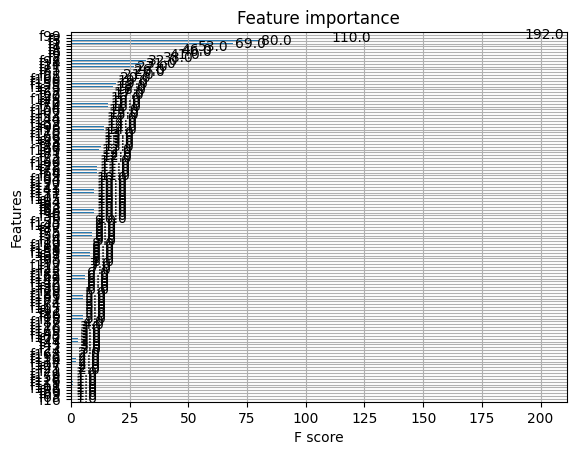

In [244]:
# Let's checkt he feature importance using XGBoost internal method
xgb.plot_importance(xg_reg, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.show()

We can see tht 4-5 features make the majority of the predictive power.

## 9. Conclusion

#### 9.1 Critique of the assignment

We have observed that our Benchmark Linear model is actually overperforming our NN models which we included text columns.

<ins>Below I have listed some of the reason why is this happening as well as further ideas how we could increase performance:<ins>

There could be several reasons why our linear model without text features performs better than your RNN model with text features included. Let's explore some potential factors:

1. Data Quality and Quantity:
We can always increase the quantity of the data. Given that our training data is 55K and Test data is 29K. Actually increasing Training data would help. Also thru Pandas Data profiling we have noticed some futher data quality issues.

3. Feature Engineering:
Our text data can be noisy and can be cleaned further. Considering that we have high amount of Out-Of-Vocabulary words can be a place to start which we did not look in this notebook. As well we have applied not so sophisticated data cleaning techniques for `non_text_features`. For example we applied to a very general outlier truncation method, this can be already taking away some important information from our data.
Another idea is actually, the way we one_hot_encoded our categorical features was made thinking of a pipeline however we could easily apply some techniques to decrease the cardinality of the categories by merging the low appearing categories together.

5. Hyperparameters:
Benchmark models as well as NN models have various hyperparameters that need to be tuned carefully, such as the number of layers, number of units in each layer, dropout rates, and learning rates. Poorly tuned hyperparameters can lead to suboptimal performance. We have only checked for some of the Hyperparameters however further we could apply some Gridsearch for the picked model and find the sweet spot for our model.

6. Overfitting:
RNN models are more prone to overfitting, especially when dealing with complex text data. If your RNN model is overfitting, it might not generalize well to new data, leading to worse performance compared to a simpler linear model. This is also possible for Tree based models.
Also generally we need to be wary of overfitting in our models and deal with it with Regularization methods in the next section as we have continuously observed that the training loss functions were continously smaller than test loss functions.

8. Sequence Length and Padding:
Generally we also applied a very out of the box padding method. We used the max_text_length for padding all text. This might basically mask shorter sequences easily. We tried to fix this a bit by applying `masked=True` in Embeddings however this is still can be further investigated.


9. Generally Model Complexity:
Sometimes, simpler models like linear regression can perform surprisingly well if the underlying relationships in the data are not complex. Adding more complexity with an RNN might not necessarily improve performance.
Text Feature Relevance:

It's also possible that the text features we've included in your RNN model might not be as relevant for the prediction task as we initially thought.!!!

## 10. Predicting for the final test_data

After we have picked the best performing model, we would need to re-train the model with the full train_data in order to predict for the full test_data and submit our predictions to Kaggle.

However before that. We would need to also apply the data transformations that was applied to sample data to full `train_data` as well as `test_data`. For this I will collect all the feature engineering, data transformation part in a wrapper function.

While submitting results for the kaggle i have tried many variations of the stacked model with different Embedding layers, different number of hidden layers and neurons, additional parameters as well as tuning the XGboost for the `non_text_features`. For the sake of this notebooks I will not be including all of these trials but just the final version.

### 10.1 Preparing the Train_Data for Final Model

In [ ]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [ ]:
# columns below might not be in the intended data type yet, we will transform them further
columns_to_binary = ['host_is_superhost','host_has_profile_pic','host_identity_verified']
category_columns = ['experiences_offered', 'host_response_time', 'property_type', 'room_type', 'bed_type',
                    'cancellation_policy', 'neighbourhood_cleansed']
category_columns_big = ['neighbourhood_cleansed', 'zip_code', 'amenities']
text_columns = ['name','summary', 'space' , 'description', 'neighborhood_overview', 'transit', 'house_rules']
string_columns = ['listing_id'] # this is the unique identifier of the table (index)
numeric_columns = ['host_id', 'host_response_rate', 'host_total_listings_count', 'review_scores_rating' 
                   ,'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'reviews_per_month',
                    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                    'review_scores_communication', 'review_scores_location', 'review_scores_value']
target_column = ['price']

In [48]:
## Let's create wrapper function for data cleaning:

def wrapper_data_cleaning_tr(df):
    #define encoder dict to return 
    encoder_dict = {}
    # date features
    df['host_since'] = pd.to_datetime(df['host_since']).map(dt.datetime.toordinal)
    # host features
    df.host_since.fillna(value = df.host_since.median(), inplace = True)
    df.host_response_rate = fix_host_response_rate(df)
    # numeric features
    for col in numeric_columns[1:]:
        df[col].fillna(value = df[col].median(), inplace = True)
    # categorical features
    for col in category_columns:
        print(col)
        df[col] = df[col].replace(np.nan,"IsMissing") # lets also deal with ismissing here
        df, encoder_dict = one_hot_encoding_train(df, col, encoder_dict) 
    # binary features
    for column in columns_to_binary:
        df[column] = convert_into_binary(df[column])
    # amenities feature
    df = encoding_amenity(df, unique_amenities)
    # droppping insignificant amenity features
    filter_col_amenity = [col for col in df if col.startswith('amenity')]
    warnings.filterwarnings("ignore")
    list_sign_cols = []
    for col in filter_col_amenity:
        _, p_sign_col = category_to_price_without_visualization(df, col)
        list_sign_cols.append(p_sign_col)
    list_sign_cols = set(list_sign_cols)
    amenities_psign_features = list(list_sign_cols)
    amenities_psign_features.remove(np.nan)
    warnings.resetwarnings()
    remove_list = [item for item in filter_col_amenity if item not in amenities_psign_features]
    df.drop(columns=remove_list, inplace=True)
    
    # Outlier Truncation & Scaling
    scaler_dict = {}
    IQR_dict = {}
    for col in num_col_to_handle:
        df[col], IQR_dict[col] = outlier_truncation(df[col])
        scaler = MinMaxScaler() #re/initialize scaler for each column
        scaler.fit(df[[col]])
        scaler_dict[col] = scaler
        scaled_column_train = scaler_dict[col].transform(df[[col]]) # lets collect trained scalers in to a dict
        df[f'scaled_{col}'] = scaled_column_train
    # text features
    for col in text_columns:
        df[col] = df[col].astype(str)
    df['all_text_features'] = df['name'] + df['space'] + df['description'] + df['neighborhood_overview'] + df['transit'] + df['house_rules']
    df['all_text_features'].fillna('', inplace=True)
    #df['clean_all_text_features'] = clean_texts(df['all_text_features'])
        
    return df, amenities_psign_features, IQR_dict, encoder_dict, scaler_dict

In [ ]:
# calling wrapper cleaning function for train_data
train_data_clean, amenities_psign_features_tr, IQR_dict, encoder_dict, scaler_dict  = wrapper_data_cleaning_tr(train_data)

In [76]:
## Let's create wrapper function for data cleaning:

def wrapper_data_cleaning_test(df, amenities_psign_features_tr, IQR_dict, encoder_dict, scaler_dict):
    # date features
    df['host_since'] = pd.to_datetime(df['host_since']).map(dt.datetime.toordinal)
    # host features
    df.host_since.fillna(value = df.host_since.median(), inplace = True)
    df.host_response_rate = fix_host_response_rate(df)
    # numeric features
    for col in numeric_columns[1:]:
        df[col].fillna(value = df[col].median(), inplace = True)
    # categorical features
    for col in category_columns:
        print(col)
        df[col] = df[col].replace(np.nan,"IsMissing") # lets also deal with ismissing here
        df = one_hot_encoding_test(df, col, encoder_dict) # Encoding Dict from Training
    # binary features
    for column in columns_to_binary:
        df[column] = convert_into_binary(df[column])
    # amenities feature
    filter_col_amenity = [col for col in df if col.startswith('amenity')]
    remove_list = [item for item in filter_col_amenity if item not in amenities_psign_features_tr]
    df.drop(columns=remove_list, inplace=True)
    # Outlier Truncation and Scaling
    for col in num_col_to_handle:
        # Outlier Truncation
        df[col] = outlier_truncation_with_IQR(df[col], IQR_dict[col]) # Using IQR dict for each feature
        # Scaling
        scaled_column_test = scaler_dict[col].transform(df[[col]])  # Scaler Dicts from Training Data
        df[f'scaled_{col}'] = scaled_column_test
    # text features
    for col in text_columns:
        df[col] = df[col].astype(str)
    df['all_text_features'] = df['name'] + df['space'] + df['description'] +df['neighborhood_overview'] +df['transit'] +df['house_rules']
    df['all_text_features'].fillna('', inplace=True)
    #df['clean_all_text_features'] = clean_texts(df['all_text_features'])
        
    return df

In [ ]:
# calling wrapper cleaning function for test_data
test_data_clean = wrapper_data_cleaning_test(test_data, amenities_psign_features_tr, IQR_dict, encoder_dict, scaler_dict)

In [139]:
## Let's load our cleaned and prepared data
#with open('train_data_cleaned_final.pkl', 'rb') as file_name:
#    test_data_clean= pickle.load(file_name)
#
#with open('test_data_cleaned_final.pkl', 'rb') as file_name:
#    test_data_clean = pickle.load(file_name)

In [246]:
# Let's load our cleaned and prepared data
with open('train_data_cleaned_final.pkl', 'rb') as file_name:
    train_data_cleaned_final= pickle.load(file_name)

with open('test_data_cleaned_final.pkl', 'rb') as file_name:
    test_data_cleaned_final = pickle.load(file_name)

In [247]:
train_data_cleaned_final.set_index("listing_id", inplace=True)
test_data_cleaned_final.set_index("listing_id", inplace=True)

In [249]:
train_data_cleaned_final.shape, test_data_cleaned_final.shape

((55284, 299), (29769, 155))

In [250]:
train_data_clean = train_data_cleaned_final
test_data_clean = test_data_cleaned_final

We notice that the onehotencoding dummy creation has created feature missmatch for some categorical columns.
I will simply delete them from test data for simplicity at this point.

In [251]:
missing_columns_test = list(set(train_data_clean.columns) - set(test_data_clean.columns))
missing_columns_train = list(set(test_data_clean.columns) - set(train_data_clean.columns))
len(missing_columns_test), len(missing_columns_train)

(144, 0)

In [252]:
# adding missing dummy features from categories to test_data

missing_dummy_data = pd.DataFrame(0, index=test_data_clean.index, columns=missing_columns_test)

# Concatenate the missing dummy data with the test_data
test_data_clean = pd.concat([test_data_clean, missing_dummy_data], axis=1)

test_data_clean.drop(columns = missing_columns_train, inplace=True)
test_data_clean.drop(columns = 'price', inplace=True)

In [253]:
train_data_clean.shape, test_data_clean.shape

((55284, 299), (29769, 298))

Looks already better.

In [254]:
def wrapper_text_embedding(df):
    # dealing with clean_all_text_features
    tokenizer_all_text = Tokenizer(oov_token=1, filters='!"#$%&()*+,-.:;<=>?@[\\]^`{|}~\t\n', lower=False)
    tokenizer_all_text.fit_on_texts(df.clean_all_text_features)
    NUM_WORDS_ALL_TEXT = len(tokenizer_all_text.word_index) + 1
    print('Printing NUM_WORDS_TEXT in text:'+str(NUM_WORDS_ALL_TEXT))
    
    tr_all_text_seq = tokenizer_all_text.texts_to_sequences(df.clean_all_text_features)
    
    max_article_length = max([len(article) for article in tr_all_text_seq])
    print('The longest article of the training set has {} words.'.format(max_article_length))
    
    MAX_ALL_TEXT_LENGTH = max_article_length #using max sentence length as the uppor bound for padding for each column
    print('MAX_ALL_TEXT_LENGTH:'+str(MAX_ALL_TEXT_LENGTH))
    
    tr_all_text_pad = pad_sequences(tr_all_text_seq, MAX_ALL_TEXT_LENGTH)
    
    wiki_weights_all_text, _ = get_embedding_matrix(tokenizer_all_text, wiki2vec, NUM_WORDS_ALL_TEXT)

    return wiki_weights_all_text, tokenizer_all_text, tr_all_text_pad, NUM_WORDS_ALL_TEXT, MAX_ALL_TEXT_LENGTH

In [255]:
tr_full_wiki_weights_all_text, tr_full_tokenizer_all_text, tr_full_all_text_pad, tr_full_NUM_WORDS_ALL_TEXT, tr_full_MAX_ALL_TEXT_LENGTH = wrapper_text_embedding(train_data_clean)

Printing NUM_WORDS_TEXT in text:91185
The longest article of the training set has 1182 words.
MAX_ALL_TEXT_LENGTH:1182
Start embedding process for 91184 words.
Created embedding matrix of shape (91185, 100) in 0.06309049924214681 min 
Encountered 59503 out-of-vocabulary words.


In [256]:
# Then use the same tokenizer to create embeddings for test data
ts_full_all_text_seq = tr_full_tokenizer_all_text.texts_to_sequences(test_data_clean.clean_all_text_features) 
ts_full_all_text_pad = pad_sequences(ts_full_all_text_seq, tr_full_MAX_ALL_TEXT_LENGTH)

In [260]:
# Collecting the features together
filter_col_scaled = [col for col in train_data_clean if col.startswith('scaled')]
filter_cat_features = []
for feat in category_columns:
    cat_feature_list = [col for col in train_data_clean if col.startswith(str(feat))]
    filter_cat_features.extend(cat_feature_list)
filter_col_amenity = [col for col in train_data_clean if col.startswith('amenity')]
other_features = ['host_since','host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
train_full_model_features = filter_col_scaled + filter_cat_features + other_features + filter_col_amenity + ['clean_all_text_features']

# for full model
X_train_data_full = train_data_clean[train_full_model_features]
X_test_data_full = test_data_clean[train_full_model_features]
X_train_data_full = X_train_data_full.drop(columns=category_columns).copy()
X_test_data_full = X_test_data_full.drop(columns=category_columns).copy()
y_train_data_full = train_data_clean['price']

In [261]:
# convert all numeric columns to float
X_train_full_wo_clean_text = np.asarray(X_train_data_full.drop(columns=['clean_all_text_features'])).astype('float32')
X_test_full_wo_clean_text = np.asarray(X_test_data_full.drop(columns=['clean_all_text_features'])).astype('float32')
#X_train_full_wo_clean_text = X_train_data_full.drop(columns=['clean_all_text_features'])
#X_test_full_wo_clean_text = X_test_data_full.drop(columns=['clean_all_text_features'])

In [262]:
X_train_full_wo_clean_text.shape, X_test_full_wo_clean_text.shape, X_train_data_full.shape, X_test_data_full.shape

((55284, 260), (29769, 260), (55284, 261), (29769, 261))

### 10.2 Train & Predict with the Final Model

In [267]:
from tensorflow import keras
# Stacking both model: biLSTM and XGBoost

## XGBoost

xgb_stack = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression task with squared error loss
    colsample_bytree=0.8,  # Fraction of features used during each boosting iteration
    learning_rate=0.05,  # Step size shrinkage used in update to prevent overfitting
    max_depth=8,  # Maximum depth of a tree
    n_estimators=1000,  # Number of boosting rounds (trees)
    subsample=0.8,  # Fraction of samples used for fitting the trees
    gamma=0,  # Minimum loss reduction required to make a further partition on a leaf node
    min_child_weight=1,  # Minimum sum of instance weight (hessian) needed in a child
    reg_lambda=1,  # L1 regularization term on weights
    reg_alpha=0.01,  # L2 regularization term on weights
    scale_pos_weight=1,  # Controls the balance of positive and negative weights
    random_state=42  # Random seed for reproducibility
)

xgb_stack.fit(X_train_full_wo_clean_text, y_train_data_full)

tr_xgb_stack_preds = xgb_stack.predict(X_train_full_wo_clean_text)


#bi-LSTM

input_text = Input(shape=(tr_full_MAX_ALL_TEXT_LENGTH, ))

# Text
text_embeddings = Embedding(tr_full_NUM_WORDS_ALL_TEXT, output_dim=100,
                     embeddings_initializer=Constant(tr_full_wiki_weights_all_text),
                     input_length=tr_full_MAX_ALL_TEXT_LENGTH, trainable=True, mask_zero=True)(input_text)

bi_LSTM_text = Bidirectional(LSTM(100, return_sequences=False), merge_mode="concat")(text_embeddings) # Setting up Birectional LSTM here
dense_text = Dense(1, activation="relu")(bi_LSTM_text)


# Add Layers
layer1 = Dense(2048, kernel_regularizer='l2', # adding l2 regularization
                    activation='relu',
                    kernel_initializer=keras.initializers.he_normal(seed=42), #initialisation of weights, 
                    bias_initializer='zeros')(dense_text) # initializer sets the biases of a layer to zero
layer2 = Dense(1024,kernel_regularizer='l2' ,activation='relu')(layer1)
layer2_d = Dropout(0.3)(layer2)
layer3 = Dense(512,kernel_regularizer='l2' ,activation='relu')(layer2_d)
layer3_d = Dropout(0.1)(layer3)
layer4 = Dense(128,kernel_regularizer='l2' ,activation='relu')(layer3_d)
output_layer = Dense(1, activation="linear")(layer4)

bi_LSTM_stack = Model(inputs=input_text, outputs = output_layer)

bi_LSTM_stack.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse', 'RootMeanSquaredError', 'msle'])
bi_LSTM_stack.summary()

callbacks = [EarlyStopping(monitor="mae", patience=3, verbose=1, min_delta=0.1, restore_best_weights=True)]

story = bi_LSTM_stack.fit(tr_full_all_text_pad, 
                  y_train_data_full, epochs=16, verbose=1, batch_size=256, callbacks=callbacks) # no validation split as we want to use the full training set

tr_stack_preds = bi_LSTM_stack.predict(tr_full_all_text_pad)

# Reshape GRU predictions
tr_stack_preds_sqzd = np.squeeze(tr_stack_preds)

# Create new dataset with predictions from both models
xgb_combined_train = np.column_stack((tr_stack_preds_sqzd, tr_xgb_stack_preds))

# Train a meta-model (XGBoost) on the training set

meta_model = xgb.XGBRegressor()

meta_model.fit(xgb_combined_train, y_train_data_full)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 1182)]            0         
                                                                 
 embedding_38 (Embedding)    (None, 1182, 100)         9118500   
                                                                 
 bidirectional_20 (Bidirecti  (None, 200)              160800    
 onal)                                                           
                                                                 
 dense_146 (Dense)           (None, 1)                 201       
                                                                 
 dense_147 (Dense)           (None, 2048)              4096      
                                                                 
 dense_148 (Dense)           (None, 1024)              2098176   
                                                          

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [268]:
# Predict 
# XGBoost
ts_xgb_stack_preds = xgb_stack.predict(X_test_full_wo_clean_text)

#bi-LSTM
ts_bilstm_stack_preds = bi_LSTM_stack.predict(ts_full_all_text_pad)
ts_bilstm_stack_preds_sqzd = np.squeeze(ts_bilstm_stack_preds)

# Create new dataset with predictions from both models
ts_xgb_bilstm_combined_preds = np.column_stack((ts_bilstm_stack_preds_sqzd, ts_xgb_stack_preds))

ts_stacked_preds_val = meta_model.predict(ts_xgb_bilstm_combined_preds)

931/931 [==============================] - 170s 182ms/step


In [270]:
predictions_df = pd.DataFrame(ts_stacked_preds_val, index=X_test_data_full.index, columns=["prediction"])
predictions_df.rename(columns={'prediction': 'price'}, inplace=True)
predictions_df
# Save predictions DataFrame
predictions_df.to_csv("submissions_baris_sen_f.csv")

In [271]:
!kaggle competitions submit -c adams-sose23 -f submissions_baris_sen_f.csv -m "Message"

100%|█████████████████████████████████████████| 599k/599k [00:02<00:00, 270kB/s]
Successfully submitted to ADAMS SoSe23